In [1140]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import time
import os

# Development of a Jukes-Cantor pipeline for generation of synthetic data

## Graph functions

In [181]:
# Function to calculate the weight of a tree split
def get_split_weight(n_L, n_R):
    '''
    Params:
        n_L, n_R : int
            Number of leaves in the left and right
            subtrees, respectively, that would result
            from the proposed split.
    Output:
        Returns the weight of the split as the amount 
        of subsequent splits that can be performed on
        the resulting subtrees:
        
            max(1, floor(n_L / 2)) * floor(n_R / 2)
            
        This results stems from removing isomorfisms
        from the possible splits, by imposing that the 
        main branches of any tree have to be ordered 
        by amount of leaves from left to right. Thus,
        n_L <= n_R.
    '''
    # Check that the constraint is fulfilled
    if np.any(n_L > n_R):
        print('Error: n_L cannot be larger than n_R.')
        return 

    n_L_term = np.clip(np.floor(n_L/2), a_min=1, a_max=n_R) 
    n_R_term = np.clip(np.floor(n_R/2), a_min=1, a_max=n_R)
    return (n_L_term * n_R_term).astype('int')


# Function to sample a split from a number of leaves
def sample_split(n_leaves):
    '''
    Params:
        n_leaves : int
            Number of current leaves in the tree to be 
            split.
    Output:
        Returns a split that is sampled non-uniformly,
        where the probability of a given split is 
        proportional to the number of possible topologies
        that can be obtained from the split.
    '''
    # Define all possible splits
    n_L = np.arange(int(np.floor(n_leaves/2))) + 1
    n_R = n_leaves - n_L

    # Get weights and probabilities
    w = get_split_weight(n_L, n_R)
    p = w / np.sum(w)

    # Sample one split
    idx = np.random.choice(np.arange(len(n_L)), p=p)
    split = [n_L[idx], n_R[idx]]

    return split
    

# Function for sampling binary tree toplogies non-uniformly
# but in a guided manner
def sample_biased_topology(n_leaves, seed=None):
    '''
    Params:
        n_leaves : int
            Number of leaves for the tree, must be greater
            than 1.
        seed : int (optional)
            Seed for the numpy random generator, not used
            by default.
    Output:
        Returns a rooted binary tree with the amount of 
        specified leaves, with a topology sampled 
        non-uniformly at random from the space of all 
        possible configurations up to isomorfism. The 
        topology is returned as nested tuple.
        
        The sampling is performed so that each sub-tree
        is sampled uniformly. This sampling is supposed to
        be used in an exploratory manner, to get all the 
        unique topologies with as little samples as possible.
    '''
    # Initialize seed if given
    if seed != None:
        np.random.seed(seed)

    # If 3 or less leaves are left, then return the
    # trivial structures
    if n_leaves == 1:
        return 1
    elif n_leaves == 2:
        return [1, 1]
    elif n_leaves == 3:
        return [1, [1, 1]]
        
    # Else, initialize tree topology
    top = []

    # Perform a split
    n_L, n_R = sample_split(n_leaves)

    # Operate recursively until all leaves are asigned
    top = [sample_biased_topology(n_L), 
           sample_biased_topology(n_R)]
    return top


# Function to turn a topology into a Graph object
def topology_to_graph(top):
    '''
    Params:
        top : array
            Nested tuple indicating the topology of a 
            binary tree.
    Output:
        Returns a networkx Graph object built from the
        specified topology.
    '''
    # Turn topology into string
    str_top = str(top)

    # Remove ones
    str_top = str_top.replace('1', '[]')

    # Evaluate to get nested tuple
    nested = eval(str_top)

    # Get Graph obejct and return
    graph = nx.from_nested_tuple(nested)
    return graph

## Jukes-Cantor model functions

In [330]:
# Function to define a JC transition matrix for a given set
# of parameters
def M_JC(t, alpha=1.):
    '''
    Params:
        t : float
            Length of the edge between the parent and child
            nodes. Must be non-negative.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Default 
            values is 1.
    Output:
        Returns a numpy array of shape (4,4) with the values
        for the transition matrix of the Jukes-Cantor model,
        over an edge of length t.
    '''
    # Define term a(t)
    a_t = (3/4) * (1 - np.exp(-4 * alpha * t / 3))
    
    # Init matrix from non-diagonal terms
    M = np.ones((4,4)) * a_t / 3

    # Set diagonal elements and return
    np.fill_diagonal(M, val=1-a_t)
    return M


# Function to generate a sequence uniformly at
# random
def draw_uniform_sequence(m, chars, seed=None):
    '''
    Params:
        m : int
            Number of characters in the sequence.
        chars : array
            List of the characters that may be used when
            building the sequence.
        seed : int (optional)
            Seed for the numpy random number generator.
            Not used by default.
    Output:
        Returns a sequence drawn uniformly at random 
        from the space of all possible sequences with
        length m and with the given possible characters.
    '''
    # Init seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Draw m characters
    seq_chars = np.random.choice(chars, size=m)

    # Concatenate into a single string and return
    seq = ''.join(seq_chars)
    return seq
    

# Function to turn a string sequence into a matrix 
# representation according to a specific vocabulary
def str_to_matrix(sequence, vocab):
    '''
    Params:
        sequence : str
            Sequence of characters.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
    Output:
        Returns a matrix representation of shape (k,l) of
        the given sequence, where k is the length of the
        sequence and l is the number of characters in the
        vocabulary.
    '''
    # Init matrix
    A = np.zeros(shape=(len(sequence), len(vocab)))

    # Fill the matrix and return
    for i, c in enumerate(sequence):
        A[i, vocab[c]] += 1
    return A


# Function to draw a new random sequence from a parent, based 
# on the JC model
def draw_JC_sequence(parent_seq, vocab, t_e, alpha=1, seed=None):
    '''
    Params:
        parent_seq : str
            Sequence of characters of the parent node.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        t_e : float
            Length of the edge between the parent and child
            nodes. Must be non-negative.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Default 
            values is 1.
        seed : int (optional)
            Seed for the numpy random number generator. Not 
            used by default.
    Output:
        Returns a new sequence for a child of the given 
        parent, drawn with the JC model based on an edge
        length t_e and transition rate alpha.
    '''
    # Init seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Get matrix representation of the parent sequence
    P_0 = str_to_matrix(parent_seq, vocab)

    # Initialize transition matrix
    M_t = M_JC(t_e, alpha=alpha)

    # Get probabilities with Einstein summation
    P = np.einsum('ki,ij->kj', P_0, M_t)

    # Draw new sequence based on the resulting probabilities
    new_seq = []
    for i in range(len(parent_seq)):
        new_char = np.random.choice(list(vocab), p=P[i,:])
        new_seq.append(new_char)

    # Join characters and return
    new_seq = ''.join(new_seq)
    return new_seq


# Function to sample a JC phylogenetic tree on a given 
# topology
def draw_JC_tree(G, m, vocab, t_scale, alpha=1, seed=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of the tree.
        m : int
            Number of characters in the sequence.
        vocab : dict
            Dictionary with the numerical mapping of the 
            possible characters.
        t_scale : float
            Scale for the exponential distribution from
            which the edge lengths will be sampled.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Default 
            values is 1.
        seed : int (optional)
            Seed for the numpy random number generator. Not 
            used by default.
    Output:
        Returns a tuple (n_seq, t_edges) with the sequence
        of each node sampled from the JC model, and the
        length of each edge.
    '''
    # Init seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Store nodes and node neighbors
    nodes = np.array(G.nodes)
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])

    # Rebuild adjacency as a dict
    adj = {a[0]:list(a[1].keys()) for a in adj}

    # Get root
    rho = int(nodes[n_neigh == 2][0])

    # Init node sequences and depth
    n_seq = {rho: draw_uniform_sequence(m, chars=list(vocab))}
    n_depth = [[rho]]

    # Initialize edge lengths
    t_edges = dict()

    # Initialize explored nodes
    n_explored = [rho]

    # Gather remaining node information and assign sequences
    current_depth = 0
    while len(n_explored) < len(nodes):
        # Get all the children of the current layer 
        children = []
        parent_map = dict()
        for n in n_depth[current_depth]: 
            c_list = [c for c in adj[n] if not c in n_explored]
            children.extend(c_list)
            # Get map to parents
            for i, c in enumerate(c_list):
                parent_map[c] = n

        # Draw children sequences with the JC model
        for c in children:
            # Retrieve parent sequence
            p_seq = n_seq[parent_map[c]]
            # Draw edge length
            t_e = np.random.exponential(scale=t_scale)
            # Draw new sequence
            c_seq = draw_JC_sequence(p_seq, vocab, t_e,
                                     alpha=alpha)
            # Register child sequence and edge length
            n_seq[c] = c_seq
            t_edges[(parent_map[c], c)] = t_e
            
        
        # Add children to the explored nodes and depth 
        n_explored.extend(children)
        n_depth.append(children)
        
        # Increase depth
        current_depth += 1

    return n_seq, t_edges

## Visualization

In [423]:
# Function to calculate the positions of the nodes
# in a tree for display
def get_tree_node_positions(G, dx, dy, dx_decay):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        dx : float
            Horizontal displacement factor between sister 
            branches. Must be grater than 0.
        dy : float
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
        dx_decay : float 
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0.
    Output:
        Returns a dictionary with the positions of each
        node in the tree, required for a correct
        visualization of the topology.
    '''
    # Store nodes and node neighbors
    nodes = np.array(G.nodes)
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])

    # Rebuild adjacency as a dict
    adj = {a[0]:list(a[1].keys()) for a in adj}

    # Get root
    rho = int(nodes[n_neigh == 2][0])

    # Init node positions and depth
    n_pos = {rho: [0,0]}
    n_depth = [[rho]]

    # Initialize explored nodes
    n_explored = [rho]

    # Gather remaining node information and assign positions
    current_depth = 0
    while len(n_explored) < len(nodes):
        # Get all the children of the current layer 
        children = []
        parent_map = dict()
        for n in n_depth[current_depth]: 
            c_list = [c for c in adj[n] if not c in n_explored]
            children.extend(c_list)
            # Get map to parents
            for i, c in enumerate(c_list):
                parent_map[c] = [n, 2*i-1]

        # Get children positions based on parents
        for c in children:
            # Retrieve parent position
            px, py = n_pos[parent_map[c][0]]
            # Get relative position
            rel_x = parent_map[c][1]
            # Register child position
            cx = px + dx * (dx_decay ** current_depth) * rel_x
            cy = py - dy
            n_pos[c] = [cx, cy]
        
        # Add children to the explored nodes and depth 
        n_explored.extend(children)
        n_depth.append(children)
        
        # Increase depth
        current_depth += 1
        
    return n_pos


# Function to visualize a rooted binary tree
def visualize_tree(G, node_size, path=None,
                   dx=1, dy=1, dx_decay=0.5):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        node_size : float
            Size of the nodes in the plot.
        path : str (optional)
            File to save the resulting image. Not used by
            default.
        dx : float (optional)
            Horizontal displacement factor between sister 
            branches. Must be grater than 0. Default is 1.
        dy : float (optional)
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
            Default is 1.
        dx_decay : float (optional)
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0. Default is
            0.5.
    Output:
        Produces a plot with the topology of the given
        tree.
    '''
    # Get node positions
    n_pos = get_tree_node_positions(G, dx, dy, dx_decay)

    # Init figure
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1,
                          dpi=200)

    # Plot graph
    nx.draw(G, pos=n_pos, ax=ax, node_size=node_size)

    plt.tight_layout()
    # Save if requested
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();


# Function to visualize a phylogenetic tree with sequence and
# edge data
def visualize_phylogenetic_tree(G, n_seq, t_edge, node_size, 
                                path=None, dx=1, dy=1, 
                                dx_decay=0.5, edge_font_size=10,
                                node_font_size=12):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        n_seq : dict
            Dictionary containing the sequence of each
            node in the tree.
        t_edge : dict
            Dictionary containing the length of each edge
            in the tree.
        node_size : float
            Size of the nodes in the plot.
        path : str (optional)
            File to save the resulting image. Not used by
            default.
        dx : float (optional)
            Horizontal displacement factor between sister 
            branches. Must be grater than 0. Default is 1.
        dy : float (optional)
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
            Default is 1.
        dx_decay : float (optional)
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0. Default is
            0.5.
        edge_font_size : int (optional)
            Font size for the edge labels. Default is 10.
        node_font_size : int (optional)
            Font size for the node labels. Default is 12.
    Output:
        Produces a plot with the topology of the given
        tree, the node sequences and the edge lengths.
    '''
    # Get node positions
    n_pos = get_tree_node_positions(G, dx, dy, dx_decay)

    # Get rounded values for the edges
    edge_labels = dict()
    for edge in t_edge:
        edge_labels[edge] = round(t_edge[edge], 2)

    # Init figure
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1,
                          dpi=200)

    # Plot graph
    nx.draw_networkx_nodes(G, pos=n_pos, ax=ax, 
                           node_size=node_size)

    # Draw node sequences
    nx.draw_networkx_labels(
        G, pos=n_pos, ax=ax, labels=n_seq, 
        font_size=node_font_size, 
        verticalalignment='center_baseline',
        horizontalalignment='center'
    )
    
    # Draw edge lengths
    edge_margin = 5
    nx.draw_networkx_edges(
        G, pos=n_pos, ax=ax, arrows=True, 
        min_source_margin=edge_margin,
        min_target_margin=edge_margin,
        style='dotted'
    )
    nx.draw_networkx_edge_labels(
        G, pos=n_pos, ax=ax, edge_labels=edge_labels,
        label_pos=0.5, font_size=edge_font_size)

    plt.tight_layout()
    # Save if requested
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();


# Function to visualize a metric tree
def visualize_metric_tree(G, t_edge, node_size,
                          path=None, dx=1, dy=1, 
                          dx_decay=0.5, edge_font_size=10):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        t_edge : dict
            Dictionary containing the length of each edge
            in the tree.
        node_size : float
            Size of the nodes in the plot.
        path : str (optional)
            File to save the resulting image. Not used by
            default.
        dx : float (optional)
            Horizontal displacement factor between sister 
            branches. Must be grater than 0. Default is 1.
        dy : float (optional)
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
            Default is 1.
        dx_decay : float (optional)
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0. Default is
            0.5.
        edge_font_size : int (optional)
            Font size for the edge labels. Default is 10.
    Output:
        Produces a plot with the topology of the given
        tree and the edge lengths.
    '''
    # Get node positions
    n_pos = get_tree_node_positions(G, dx, dy, dx_decay)

    # Get rounded values for the edges
    edge_labels = dict()
    for edge in t_edge:
        edge_labels[edge] = round(t_edge[edge], 2)

    # Init figure
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1,
                          dpi=200)

    # Plot graph
    nx.draw_networkx_nodes(G, pos=n_pos, ax=ax, 
                           node_size=node_size)
    
    # Draw edge lengths
    edge_margin = 5
    nx.draw_networkx_edges(
        G, pos=n_pos, ax=ax, arrows=True, 
        min_source_margin=edge_margin,
        min_target_margin=edge_margin,
        style='dotted'
    )
    nx.draw_networkx_edge_labels(
        G, pos=n_pos, ax=ax, edge_labels=edge_labels,
        label_pos=0.5, font_size=edge_font_size)

    plt.tight_layout()
    # Save if requested
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();

## Testing 

### Checking the correct behavior of our graph generation pipeline

In [169]:
# Let's check that our topology sampler works properly under the imposed 
# constraints, for small values of n:
# Set overall seed
np.random.seed(42)

# Get samples
N = 10
N_samples = int(1e6)
samples = [str(sample_biased_topology(N)) for i in range(N_samples)]
samples = pd.Series(samples)

# Get unique counts
unique_counts = list(samples.value_counts())
num_unique = len(unique_counts)

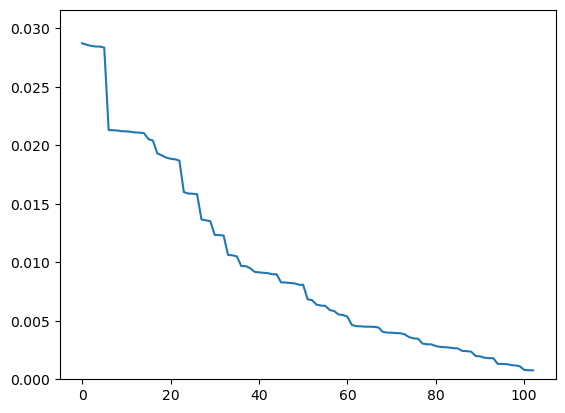

In [170]:
# Plot results
plt.plot(np.arange(num_unique), np.array(unique_counts) / N_samples)
plt.ylim(bottom=0, top = 1.1 * np.max(unique_counts) / N_samples);

In [254]:
# Let's sample one tree and visualize its topology
test_tree = sample_biased_topology(n_leaves=10, seed=1234)
test_graph = topology_to_graph(test_tree)

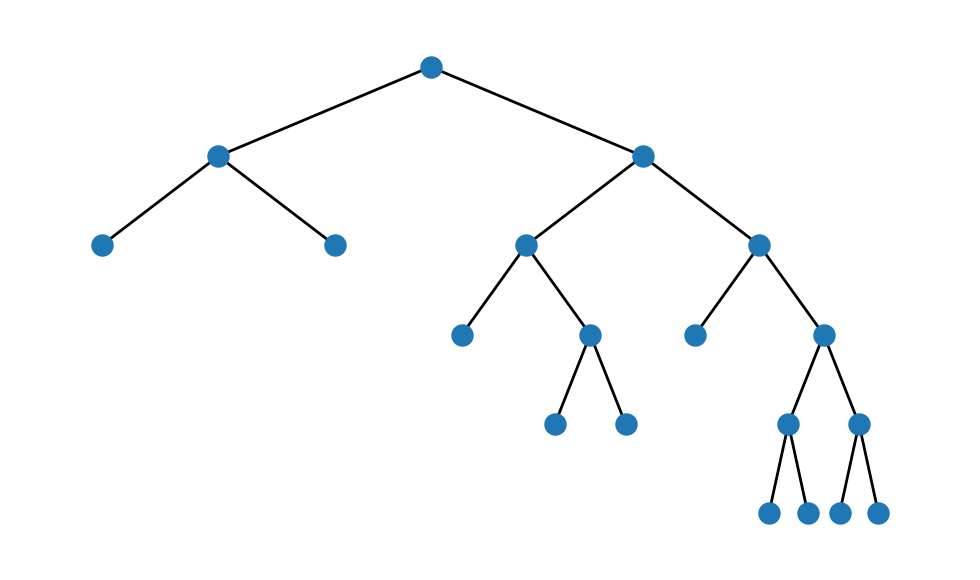

In [272]:
#nx.draw_planar(test_graph)
visualize_tree(test_graph, node_size=50, dx_decay=0.55,
               path='../Figures/test_tree_display_n_10.png')

### Checking the correct behavior of the JC generative process

In [299]:
# Let's check that the JC transition matrix is correct
M_jc_test = M_JC(1)
print(M_jc_test)
print(np.sum(M_jc_test, axis=1))

[[0.44769785 0.18410072 0.18410072 0.18410072]
 [0.18410072 0.44769785 0.18410072 0.18410072]
 [0.18410072 0.18410072 0.44769785 0.18410072]
 [0.18410072 0.18410072 0.18410072 0.44769785]]
[1. 1. 1. 1.]


In [312]:
# Define a vocabulary for testing
DNA_vocab = {'A': 0, 'G': 1, 'C': 2, 'T': 3}

# Uniformly draw a random sequence for our root
test_root_seq = draw_uniform_sequence(m=10, chars=list(DNA_vocab), seed=1234)

print('Root sequence:', test_root_seq)
print('Matrix representation:')
print(str_to_matrix(test_root_seq, DNA_vocab))

Root sequence: TTCGAAAGTG
Matrix representation:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [327]:
# Check for correct JC sampling 
t_e = 0.3
test_child_seq = draw_JC_sequence(test_root_seq, DNA_vocab, t_e=t_e,
                                 seed=1234)
print(f'Child sequence from a JC process with t_e = {t_e}')
print(test_child_seq)

Child sequence from a JC process with t_e = 0.3
CTCGGAAGTC


In [387]:
# Check for correct generation of a synthetic JC tree
test_tree = sample_biased_topology(n_leaves=7, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=5, vocab=DNA_vocab,
                            t_scale=2, seed=1234)

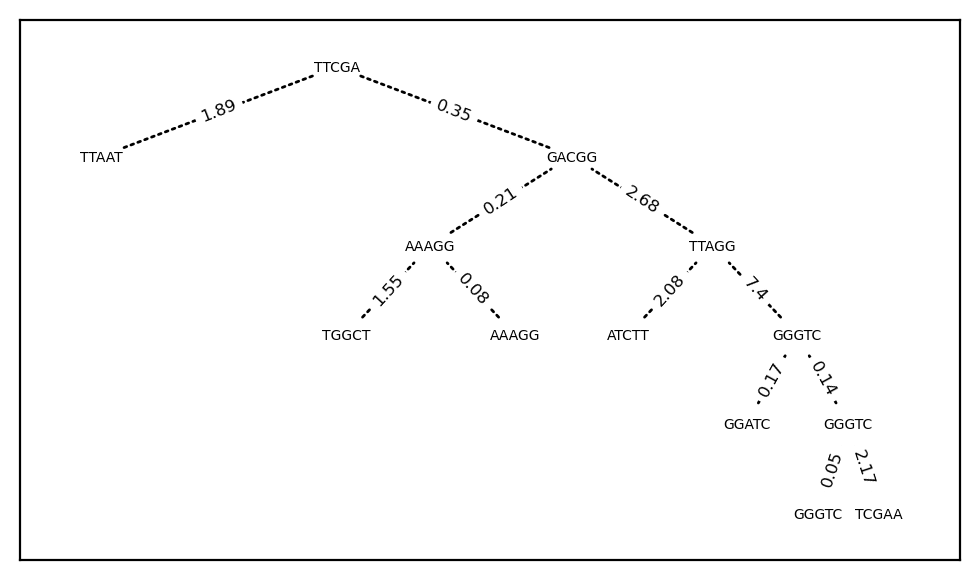

In [405]:
# Let's visualize the tree we generated
visualize_phylogenetic_tree(
    test_G, test_JC_tree[0], test_JC_tree[1], node_size=0, 
    dx_decay=0.6, edge_font_size=6, node_font_size=5, 
    path='../Figures/test_phyl_tree_display_n_7_m_5.png')

# Development of an inference pipeline

## Graph functions

In [1197]:
# Function to retrieve the labels of tree leaves
def get_leaf_labels(G, labels):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree.
        labels : dict
            Dictionary containing the labels of all the nodes
            in G.
    Output:
        Returns a dictionary mapping the leaf nodes of the 
        given tree to their corresponding labels.
    '''
    # Init new label map
    new_labels = dict()
    
    # Get leaf nodes
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])
    leaf_nodes = [adj[i][0] for i in range(len(adj)) if n_neigh[i] == 1]

    # Build new label mapping only for the leaf nodes
    for n in leaf_nodes:
        new_labels[n] = labels[n]

    return new_labels


# Function to get the internal nodes and edges of an unrooted
# tree
def get_internal_nodes_and_edges(G):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of an unrooted binary
            tree.
    Output:
        Returns a tuple (internal_nodes, internal_edges) with 
        the internal nodes and edges of the tree, defined as 
        the nodes with coordination 3 and the edges between 
        them, respectively.
    '''
    # Get internal nodes
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])
    internal_nodes = [adj[i][0] for i in range(len(adj)) if n_neigh[i] == 3]

    # Get internal edges
    edges = G.edges(internal_nodes)
    internal_edges = [(e[0], e[1]) for e in edges\
                      if (e[0] in internal_nodes)\
                      and (e[1] in internal_nodes)]

    return internal_nodes, internal_edges


# Function that turns a rooted binary tree into an unrooted one
def remove_root(G, dist_dict=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary 
            tree.
        dist_dict : dict (optional)
            Dictionary containing the edge lengths. If given,
            the edge lengths are updated after removing the
            root.
    Output:
        Returns a new networkx Graph object with an unrooted
        version of the given tree.
    '''
    # Init new graph
    G_new = G.copy()

    # Get node coordination
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])

    # Find the only node with degree 2 and the neighbors
    root, neigh = adj[np.argmax(n_neigh == 2)]
    neigh = list(neigh)

    # If lengths are given, update them as graph attribute
    if dist_dict != None:
        nx.set_edge_attributes(G_new, dist_dict, name='length')
        # Get root edges lengths
        root_lengths = [G_new[root][n]['length'] for n in neigh]

    # Remove root
    G_new.remove_node(root)

    if dist_dict != None:
        # Add new edge between root neighbors, with new length
        G_new.add_edge(neigh[0], neigh[1], 
                       length=sum(root_lengths))
    else:
        # Add new edge between root neighbors
        G_new.add_edge(neigh[0], neigh[1])
    
    return G_new


# Function to add a root to an unrooted binary tree
def add_root(G, seed=None, dist_dict=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of an unrooted binary
            tree.
        seed : int (optional)
            Seed for the numpy random generator. Not used by
            default. Only used when dist_dict is not given.
        dist_dict : dict (optional)
            Dictionary containing the length of each edge. Not
            used by default.
    Output:
        Returns a new networkx Graph object with a rooted
        version of the given tree. The root is placed by
        choosing an internal edge at random, and adding a node
        in between the corresponding nodes. If dist_dict is
        given, then the root is placed at the internal edge with
        maximum length, and an updated length dictionary is also
        returned.
    '''
    # Init random seed if dist_dict is not given
    if seed != None and dist_dict == None:
        np.random.seed(seed)

    # Init new graph
    G_new = G.copy()

    # Get internal nodes and edges
    internal_nodes, internal_edges = get_internal_nodes_and_edges(G)

    # Define root node id
    if 0 in list(G_new.nodes()):
        root_id = int(np.max(G_new.nodes()) + 1)
    else:
        root_id = 0

    # If edge length is given, choose longest edge and add root
    if dist_dict != None:
        # Get longest edge
        nx.set_edge_attributes(G_new, values=dist_dict, name='length')
        internal_e_length = [G_new[e[0]][e[1]]['length']\
                             for e in internal_edges]
        root_edge = internal_edges[np.argmax(internal_e_length)]
        root_length = float(np.max(internal_e_length))

        # Remove selected edge
        G_new.remove_edge(root_edge[0], root_edge[1])

        # Add root            
        G_new.add_edge(root_id, root_edge[0], length=root_length / 2)
        G_new.add_edge(root_id, root_edge[1], length=root_length / 2)

        # Update length dict
        dist_dict_new = nx.get_edge_attributes(G_new, name='length')

        # Return new graph and updated length dict
        return G_new, dist_dict_new

        
    # Else choose a random edge for the root
    root_edge_id = np.random.randint(low=0, high=len(internal_edges))
    root_edge = internal_edges[root_edge_id]
    # Remove selected edge
    G_new.remove_edge(root_edge[0], root_edge[1])
    # Add root            
    G_new.add_edge(root_id, root_edge[0])
    G_new.add_edge(root_id, root_edge[1])

    return G_new


# Function to perform a NNI move for a given graph
def NNI_move(G, seed=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of an unrooted binary
            tree.
        seed : int (optional)
            Seed for the numpy random generator. Not used by
            default.
    Output:
        Returns a networkx Graph object with a new binary tree
        topology, obtained by performing a nearest neighbor 
        interchange (NNI) operation on the given graph.
    '''
    # Init seed of given
    if seed != None:
        np.random.seed(seed)

    # Init new graph
    G_new = G.copy()

    # Get internal nodes and edges
    internal_nodes, internal_edges = get_internal_nodes_and_edges(G)

    # Choose an internal edge and get the parent nodes
    p1, p2 = internal_edges[np.random.randint(len(internal_edges))]

    # Select one external component for each node
    neigh_p1 = [n for n in G_new.neighbors(p1) if not n == p2]
    neigh_p2 = [n for n in G_new.neighbors(p2) if not n == p1]

    ex1 = np.random.choice(neigh_p1)
    ex2 = np.random.choice(neigh_p2)

    # Register original edge lengths
    l1 = G[ex1][p1]['length']
    l2 = G[ex2][p2]['length']

    # Remove external component edges
    G_new.remove_edge(ex1, p1)
    G_new.remove_edge(ex2, p2)

    # Remap to new edges with registered lengths
    G_new.add_edge(ex2, p1, length=l1)
    G_new.add_edge(ex1, p2, length=l2)

    return G_new


# Function to perform a SPR move for a given graph
def SPR_move(G, seed=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of an unrooted binary
            tree.
        seed : int (optional)
            Seed for the numpy random generator. Not used by
            default.
    Output:
        Returns a networkx Graph object with a new binary tree
        topology, obtained by performing a subtree prune and 
        regraft (SPR) operation on the given graph.
    '''
    # Init seed of given
    if seed != None:
        np.random.seed(seed)

    # Init new graph
    G_new = G.copy()

    # Get internal nodes and edges
    internal_nodes, internal_edges = get_internal_nodes_and_edges(G)

    # Choose an internal edge and corresponding node to prune
    n_prune, n_keep = internal_edges[np.random.randint(len(internal_edges))]

    # Register length of the edge and remove it
    l_prune = G[n_prune][n_keep]['length']
    G_new.remove_edge(n_prune, n_keep)

    # Get largest connected component as the subgraph for the keep node
    cc = [n for n in nx.connected_components(G_new)]
    cc_keep = cc[np.argmax([len(c) for c in cc])]
    # Remap node roles if necessary
    if not n_keep in cc_keep:
        n_keep, n_prune = n_prune, n_keep

    # Select an edge to regraft (avoid nearest neighbors) from the
    # opposite connected component
    regraft_edges = [e for e in G_new.edges(cc_keep) if not n_keep in e]
    regraft_e = regraft_edges[np.random.randint(len(regraft_edges))]

    # Make new internal node at regraft position:
    # Get nodes and length
    r1, r2 = regraft_e
    l_r1_r2 = G_new[r1][r2]['length']
    # Remove original edge
    G_new.remove_edge(r1, r2)
    # Create new node and edges
    new_n = int(np.max(list(G_new.nodes())) + 1)
    G_new.add_edge(new_n, r1, length=l_r1_r2 / 2)
    G_new.add_edge(new_n, r2, length=l_r1_r2 / 2)

    # Regraft subtree to the new node
    G_new.add_edge(new_n, n_prune, length=l_prune)

    # Simplify graph (remove root-like nodes)
    G_new = remove_root(
        G_new, dist_dict=nx.get_edge_attributes(G_new, name='length'))

    return G_new

## Jukes-Cantor model functions

In [804]:
# Function that calculates the conditional probability of two
# leaves from the parent node, within the JC model
def JC_leaves_conditional(p1, p2, l1, l2, alpha):
    '''
    Params:
        p1, p2 : numpy array
            Arrays of shape (m,4) with the probability 
            distribution of leaves 1 and 2 respectively, where
            m is the number of characters in a leaf sequence.
        l1, l2 : float
            Edge lenghts between the leaves 1 and 2, and the 
            parent node, respectively. Must be non-negative.
        alpha : float
            Jukes-Cantor transition rate parameter. Must be 
            non-negative.
    Output:
        Returns the conditional probability distribution of
        the given leaves at the parent node, according to the
        Jukes-Cantor model, as an array of shape (m,4).
    '''
    # Define transition matrix for each edge
    M1 = M_JC(l1, alpha)
    M2 = M_JC(l2, alpha)

    # Calculate weight matrices
    w1 = np.einsum('kj,ij->ki', p1, M1)
    w2 = np.einsum('kj,ij->ki', p2, M2)

    # Calculate conditional probability and return
    c = w1 * w2
    return c
    

# Function to calculate the joint probability of a tree, within
# the JC model
def get_JC_probability(G, leaf_labels, dist_dict, alpha, vocab):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        dist_dict : dict
            Dictionary containing the length of each edge in
            the tree.
        alpha : float
            Jukes-Cantor transition rate parameter. Must be 
            non-negative.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
    Output:
        Returns the log-probability of the tree leaves by
        performing Felsenstein's algorithm.
    '''
    # Init copy of the topology for reduction
    G_prime = G.copy()

    # Store lengths directly into the graph
    nx.set_edge_attributes(G_prime, dist_dict, name='length')

    # Init root base distribution
    p_rho = np.ones(shape=(len(vocab),)) / len(vocab)

    # Map initial leaf sequences to matrices
    leaf_p = [{n: str_to_matrix(leaf_labels[n], vocab)\
               for n in leaf_labels}]

    # Perform iterative reductions until reaching the root
    finished = False
    while not finished:
        # Gather current leaves
        current_leaves = leaf_p[-1]
        # Get leaf neighbors
        leaf_neigh = [list(G_prime[lf])[0] for lf in current_leaves]
        # Find cherries
        cherries = [(n1, n2) for i,n1 in enumerate(current_leaves)\
                    for j,n2 in enumerate(current_leaves)\
                    if (leaf_neigh[i] == leaf_neigh[j])\
                        and (n1 != n2) and (j > i)]
    
        # Solve cherries
        new_leaves = dict()
        for c in cherries:
            # Get parent
            parent = list(G_prime[c[0]])[0]
            # Get parent-leaf lengths
            l1 = G_prime[c[0]][parent]['length']
            l2 = G_prime[c[1]][parent]['length']
            # Get conditional probabilities
            cond_p = JC_leaves_conditional(
                current_leaves[c[0]], current_leaves[c[1]], 
                l1, l2, alpha)
            new_leaves[parent] = cond_p
    
        # Flatten cherries and remove from the graph
        cherries = np.array(cherries).flatten()
        for c in cherries:
            G_prime.remove_node(c)
    
        # Complete new leaves
        for lf in current_leaves:
            if not lf in cherries:
                new_leaves[lf] = current_leaves[lf]
        leaf_p.append(new_leaves)

        # Check for finish
        if len(new_leaves) < 2:
            finished = True
    
    # Get likelihood for each site
    rho_cond = leaf_p[-1][list(leaf_p[-1])[0]]
    p_final = np.einsum('i,ki->k', p_rho, rho_cond)

    # Get total log-likelihood
    log_likelihood = np.sum(np.log(p_final))
    
    return log_likelihood


# Function that finds the cherries of a given tree
def find_cherries(G):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree.
    Output:
        Returns a nested tuple with the cherries of the 
        given tree.
    '''
    # Make a copy of the original graph
    G_prime = G.copy()

    # Find the root:
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])
    root = adj[np.argmax(n_neigh == 2)][0]

    # Init cherry-parent map
    cherry_parents = dict()
    
    # Proceed in a level-wise manner until completion
    finished = False
    while not finished:
        # Create new current leaves
        current_leaves = [n for n in G_prime.nodes() if len(G_prime[n]) == 1]

        # Get leaf neighbors
        leaf_neigh = [list(G_prime[lf])[0] for lf in current_leaves]

        # Clean cherries and find new level
        cherries = []
        for i in range(len(current_leaves)-1):
            n1 = current_leaves[i]
            for j in range(i+1,len(current_leaves)):
                n2 = current_leaves[j]
                if (leaf_neigh[i] == leaf_neigh[j]) and (n1 != n2):
                    cherries.extend([n1, n2])
                    cherry_parents[str(leaf_neigh[i])] = (n1, n2)
        
        # Remove current cherries from the graph
        for c in cherries:
            G_prime.remove_node(c)

        # Check for finish
        if len(current_leaves) < 2:
            finished = True
            continue

    # Build cherry hierarchy from the parent map
    cherry_structure = 'frozenset(( ' + str(root) + ' ))'
    cherry_structure = cherry_structure.split()

    while True:
        cherry_change = False
        for p in cherry_parents:
            if p in cherry_structure:
                # Replace parent for children
                idx = cherry_structure.index(p)
                lf = cherry_parents[p]
                cherry_structure[idx] = 'frozenset(( ' + str(lf[0]) +\
                                        ' , ' + str(lf[1]) + ' ))'
                # Reformat the structure array
                cherry_structure = ' '.join(cherry_structure)
                cherry_structure = cherry_structure.split()

                # Register change
                cherry_change = True

        if not cherry_change:
            break

    # Final format for the cherries and return
    cherry_structure = ''.join(cherry_structure)
    cherry_structure = eval(cherry_structure)
    
    return cherry_structure

## MCMC functions

### Helper functions

In [1363]:
# Function to propose edge length transitions
def t_propose(t, gamma_0=1/2):
    '''
    Params:
        t : float
            Edge length value.
        gamma_0 : float (optional)
            Parameter that determines the maximum and
            minimum value for the scaling exponent.
            Default value is 1/2.
    Output:
        Returns a new value t', generated by scaling 
        the given value t by a factor e^gamma, where
        gamma ~ U(-gamma_0, gamma_0).
    '''
    s = np.exp(np.random.uniform(-gamma_0, gamma_0))
    return t * s


# Function that gives the log-Hastings ratio between
# old and new edge lengths
def log_Hastings_ratio(t_new, t_old, lamb):
    '''
    Params:
        t_new : float
            New length for a given edge of a tree.
        t_old : float
            Old length for the same edge as t_new.
        lamb : float
            Scale parameter for the exponential 
            prior.
    Output:
        Returns the log-Hastings ratio, defined as:
            log[P({t_new}) / P({t_old})]
        where P(t) is an exponential prior for
        edge lengths with scale parameter lamb.
    '''
    dt = t_new - t_old
    log_ratio = -lamb * dt
    return log_ratio


# Function to perform an internal MC step for a given tree
def internal_MC_step(G, leaf_labels, vocab,
                     lamb, gamma_0=1/2, alpha=1.):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree. The edges of the graph must have a 'length'
            attribute.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        lamb : float
            Scale parameter for the exponential prior.
        gamma_0 : float (optional)
            Parameter that determines the maximum and minimum
            value for the scaling exponent. This is used when
            proposing new edge lengths via a scale operation.
            Default value is 1/2.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Must be 
            non-negative. Default is 1.
    Output:
        Performs an internal MC step over the given tree. 
        This is done by proposing an edge scaling N times,
        where N is the number of edges in the tree. Each 
        proposal is accepted with probability:
            P(S|t') * P(t') / [P(S|t) * P(t)]
        where P(S|t) is the likelihood of the data given an
        edge length t for the selected edge, and P(t) is an
        exponential prior.
        Returns the resulting graph after the internal MC
        step, as well as MC performance statistics.
    '''
    # Make a copy of the original graph
    G_old = G.copy()
    # Get edges and their number
    all_edges = list(G_old.edges())
    N_E = len(all_edges)

    # Initialize MC info
    n_accepted = 0

    # Propose N_E changes
    for i in range(N_E):
        # Pick an edge randomly
        e_idx = np.random.randint(N_E)
        edge = all_edges[e_idx]

        # Get original length and propose new one
        t_old = G_old[edge[0]][edge[1]]['length']
        t_new = t_propose(t_old, gamma_0=gamma_0)

        # Make a copy of the old graph and apply change
        G_new = G_old.copy()
        G_new.remove_edge(edge[0], edge[1])
        G_new.add_edge(edge[0], edge[1], length=t_new)

        # Calculate acceptance probability:
        # Log-likelihood terms
        log_L_new = get_JC_probability(
            G_new, leaf_labels, nx.get_edge_attributes(G_new, 'length'), 
            alpha=alpha, vocab=vocab)
        log_L_old = get_JC_probability(
            G_old, leaf_labels, nx.get_edge_attributes(G_old, 'length'), 
            alpha=alpha, vocab=vocab)
        
        Delta_P = log_L_new - log_L_old

        # Log-prior term
        log_prior_ratio = log_Hastings_ratio(t_new, t_old, lamb)

        # Accept or reject proposal
        acc_prob = np.exp(Delta_P + log_prior_ratio)
        if acc_prob > np.random.uniform():
            # Set old graph from new
            G_old = G_new.copy()

            # Increase count of accepted proposals
            n_accepted += 1

    # Report MC stats
    MC_stats = {'int_acc_ratio': n_accepted / N_E,
                'int_N_accepted': n_accepted,
                'int_N_total': N_E}
    
    return G_old, MC_stats


# Function to perform an external MC step on a given tree
def external_MC_step(G, leaf_labels, vocab, alpha=1.,
                     N_SPR=1):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree. The edges of the graph must have a 'length'
            attribute.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Must be 
            non-negative. Default is 1.
        N_SPR : int (optional)
            Number of SPR moves to attempt. Default is 1.
    Output:
        Performs an external MC step over the given tree. 
        This is done by proposing N_int NNI moves and N_SPR 
        SPR move, where N_int is the number of internal edges
        in the tree. Each proposal is accepted with 
        probability:
                        P(S|T') / P(S|T)
        where P(S|T) is the likelihood of the data given a
        tree topology T.
        Returns the resulting graph after the external MC
        step, as well as MC performance statistics.
    '''
    # Make a copy of the original graph
    G_old = G.copy()

    # Get internal edges and their number
    internal_edges = get_internal_nodes_and_edges(G)[1]
    N_int = len(internal_edges)

    # Initialize MC info
    n_accepted_NNI = 0
    n_accepted_SPR = 0

    # Propose N_int NNI moves and N_SPR SPR moves
    for i in range(N_int + N_SPR):
        # Make a copy of the old graph and remove root
        dist_dict = nx.get_edge_attributes(G_old, 'lenght')
        G_new = remove_root(G_old.copy(), dist_dict)
        
        # Apply move
        if i < N_int:
            G_new = NNI_move(G_new)
        else:
            G_new = SPR_move(G_new)

        # Add root again
        dist_dict = nx.get_edge_attributes(G_new, 'length')
        G_new, dist_dict = add_root(G_new, dist_dict=dist_dict)

        # Calculate acceptance probability:
        # Log-likelihood terms
        log_L_new = get_JC_probability(
            G_new, leaf_labels, dist_dict, alpha=alpha, vocab=vocab)
        log_L_old = get_JC_probability(
            G_old, leaf_labels, nx.get_edge_attributes(G_old, 'length'), 
            alpha=alpha, vocab=vocab)
        
        Delta_P = log_L_new - log_L_old

        # Accept or reject proposal
        acc_prob = np.exp(Delta_P)
        if acc_prob > np.random.uniform():
            # Set old graph from new
            G_old = G_new.copy()

            # Increase count of accepted proposals
            if i < N_int:
                n_accepted_NNI += 1
            else:
                n_accepted_SPR += 1

    
    # Report MC stats
    MC_stats = {'ext_acc_ratio': (n_accepted_NNI + n_accepted_SPR)\
                                 / (N_int + N_SPR),
                'ext_acc_ratio_NNI': n_accepted_NNI / N_int,
                'ext_acc_ratio_SPR': n_accepted_SPR / N_SPR,
                'ext_N_accepted_NNI': n_accepted_NNI,
                'ext_N_accepted_SPR': n_accepted_SPR,
                'ext_N_total_NNI': N_int,
                'ext_N_total_SPR': N_SPR,
    }

    return G_old, MC_stats


# Function to calculate the log-posterior of a given graph
def log_posterior_JC(G, leaf_labels, lamb, vocab, alpha=1):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree. The edges of the graph must have a 'length'
            attribute.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        lamb : float
            Scale parameter for the exponential prior.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Must be 
            non-negative. Default is 1.
    Output:    
        Returns the log-posterior of the given graph. It
        assumes an exponential prior for the edge lengths.
    '''
    # Get log-likelihood
    edge_lengths = nx.get_edge_attributes(G, 'length')
    log_P = get_JC_probability(G, leaf_labels, edge_lengths, 
                                alpha=alpha, vocab=vocab)
    # Get edge lengths as an array
    edge_lengths = [edge_lengths[n] for n in edge_lengths]
    
    # Add log prior and return
    log_P += np.log(lamb) - lamb * np.sum(edge_lengths)
    return log_P


# Function to save a tree graph into a GML file
def save_tree_to_GML(G, node_labels, path):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree. The edges of the graph must have a 'length'
            attribute.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        path : str
            Path to the file in which the GML representation 
            will be written.
    Output:
        Writes the given graph to the specified file as a GML
        representation.
    '''
    # Make a copy of the graph
    G_new = G.copy()
    # Write leaf labels to the graph
    nx.set_node_attributes(G_new, leaf_labels, name='sequence')
    # Write file
    nx.write_gml(G_new, path=path)
    return None



# Function to sample edge lengths from a given tree
def sample_edge_lengths(G, burnin_steps, sampling_steps, leaf_labels, 
                        vocab, lamb, gamma_0=0.5, alpha=1., seed=None):
    '''
    Params:
        G : networkx Graph
            Graph containing the topology of a rooted binary
            tree. The edges of the graph must have a 'length'
            attribute.
        burnin_steps : int
            Number of MC steps to use for the burn-in period.
            During this period the topology and parameters of 
            the tree are updated, but the obtained samples
            are discarded.
        sampling_steps : int
            Number of MC steps to use for sampling, after the
            burn-in stage has been completed.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        lamb : float
            Scale parameter for the exponential prior.
        gamma_0 : float (optional)
            Parameter that determines the maximum and minimum
            value for the scaling exponent. This is used when
            proposing new edge lengths via a scale operation.
            Default value is 1/2.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Must be 
            non-negative. Default is 1.
        seed : int (optional)
            Seed for the numpy random generator. Not used by
            default
    Output:
        Returns a dictionary where each key is an edge of the
        given tree, and the value is an array of sampled 
        lengths for that edge. The sampling is done by fixing
        the tree topology and performing MCMC steps only for 
        the edge lengths. Also returns a dictionary with
        information on the sampling process.
    '''
    # Set seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Copy original tree
    G_prime = G.copy()

    # Generate intial lengths for the tree
    sequences = [leaf_labels[lf] for lf in leaf_labels]
    N_char = len(sequences[0])
    _, edge_lengths = draw_JC_tree(
        G, m=N_char, t_scale=1/lamb_t, vocab=vocab)

    # Assign edge lengths
    nx.set_edge_attributes(G_prime, edge_lengths, name='length')

    # Init MC information and edge samples
    burnin_stats = None
    sampling_stats = None
    edge_samples = {e: [] for e in edge_lengths}

    # Perform burn-in steps
    for i in range(burnin_steps):
        # Internal MC step
        G_prime, new_stats = internal_MC_step(G_prime, leaf_labels, vocab, 
                                      lamb, gamma_0, alpha)
        new_stats = pd.DataFrame(new_stats, index=[i])

        # Calculate log-posterior and add to stats
        log_P = log_posterior_JC(G_prime, leaf_labels, lamb, 
                                 vocab, alpha)
        new_stats['log_P'] = [log_P]

        # Register stats
        if i == 0:
            burnin_stats = new_stats
        else:
            burnin_stats = pd.concat([burnin_stats, new_stats], 
                                    axis=0)

    # Perform sampling steps
    for i in range(sampling_steps):
        # Internal MC step
        G_prime, new_stats = internal_MC_step(G_prime, leaf_labels, vocab, 
                                              lamb, gamma_0, alpha)
        new_stats = pd.DataFrame(new_stats, index=[i])

        # Calculate log-posterior and add to stats
        log_P = log_posterior_JC(G_prime, leaf_labels, lamb, 
                                 vocab, alpha)
        new_stats['log_P'] = [log_P]

        # Register stats
        if i == 0:
            sampling_stats = new_stats
        else:
            sampling_stats = pd.concat([sampling_stats, new_stats], 
                                    axis=0)

        # Save edge length samples
        for e in edge_samples:
            edge_samples[e].append(G_prime[e[0]][e[1]]['length'])
        

    return edge_samples, burnin_stats, sampling_stats

### Main pipeline function

In [1466]:
# Function to perform a complete inference run
def run_inference(sequences, path, burnin_steps, sampling_steps,
                 vocab, lamb_t, alpha=1., gamma_0=0.5, N_SPR=1,
                  seed=None, verbose=True):
    '''
    Params:
        sequences : array
            Array of aligned sequences for which to infer the 
            phylogenetic tree.
        path : str
            Path to a folder in which the inference results 
            will be saved.
        burnin_steps : int
            Number of MC steps to use for the burn-in period.
            During this period the topology and parameters of 
            the tree are updated, but the obtained samples
            are discarded.
        sampling_steps : int
            Number of MC steps to use for sampling, after the
            burn-in stage has been completed.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        lamb_t : float
            Scale parameter for the exponential prior of the 
            edge lengths.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Must be 
            non-negative. Default is 1.
        gamma_0 : float (optional)
            Parameter that determines the maximum and minimum
            value for the scaling exponent. This is used when
            proposing new edge lengths via a scale operation.
            Default value is 1/2.
        N_SPR : int (optional)
            Number of SPR moves to attempt in every external
            MC step. Default is 1.
        seed : int (optional)
            Seed for the numpy random generator. Not used by
            default
        verbose : bool (optional)
            Whether to print process notifications or not.
            Default is True.
    Output:
        Runs a complete inference process on the given set of
        sequences.
    '''
    # Start timing 
    t1 = time.time()

    # Create directory if not already present
    os.makedirs(path, exist_ok=True)
    
    # Set seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Get number of leaves and sequence length
    N_leaves = len(sequences)
    N_char = len(sequences[0])
    
    # First, we need to create a random topology from which 
    # to start
    if verbose:
        print('Initializing tree graph')
    tree = sample_biased_topology(n_leaves=N_leaves)
    G = topology_to_graph(tree)

    # Generate tree edge lengths and assign them to the graph
    _, edge_lengths = draw_JC_tree(
        G, m=N_char, t_scale=1/lamb_t, vocab=vocab)

    # Get id of the tree leaf nodes
    leaf_nodes = [n for n in G.nodes() if len(G[n]) == 1]

    # Propose N_leaf different arrangements of the labels
    leaf_proposals = [np.random.choice(range(N_leaves), 
                            size=N_leaves, replace=False)\
                      for i in range(N_leaves)]
    tree_proposals = [
        {leaf_nodes[i]: sequences[leaves[i]] for i in range(N_leaves)}\
        for leaves in leaf_proposals
    ]

    # Calculate likelihood for each and move forwards with
    # the maximum likelihood choice
    prop_log_likelihood = [get_JC_probability(G, prop_labels, edge_lengths, 
                                           alpha=alpha, vocab=vocab)\
                            for prop_labels in tree_proposals]

    leaf_labels = tree_proposals[np.argmax(prop_log_likelihood)]

    # Save leaf labels for later use
    df_leaf_labels = {'node': [lf for lf in leaf_labels],
                      'sequence': [leaf_labels[lf] for lf in leaf_labels]}
    df_leaf_labels = pd.DataFrame(df_leaf_labels)
    df_leaf_labels.to_csv(path + 'leaf_labels.csv', index=False)

    # Store lengths into graph
    nx.set_edge_attributes(G, edge_lengths, name='length')

    # Init burn-in stats
    burnin_stats = None
    
    # Perform burn-in period
    if verbose:
        print('Performing burn-in stage')
    for i in range(burnin_steps):
        # External MC step
        G, new_stats_ext = external_MC_step(G, leaf_labels, vocab, 
                                            alpha=alpha, N_SPR=N_SPR)
        new_stats_ext = pd.DataFrame(new_stats_ext, index=[i])

        # Internal MC step
        G, new_stats_int = internal_MC_step(G, leaf_labels, vocab, 
                                           lamb, gamma_0, alpha)
        new_stats_int = pd.DataFrame(new_stats_int, index=[i])

        # Join external and internal stats
        new_stats = pd.concat([new_stats_ext, new_stats_int],
                                     axis=1)

        # Calculate log-posterior and add to stats
        log_P = log_posterior_JC(G, leaf_labels, lamb, 
                                 vocab, alpha)
        new_stats['log_P'] = [log_P]

        # Register stats
        if i == 0:
            burnin_stats = new_stats
        else:
            burnin_stats = pd.concat([burnin_stats, new_stats], 
                                    axis=0)


    # Init sampling stats
    sampling_stats = None

    # Init tracking of unique topologies
    os.makedirs(path+'frozen/', exist_ok=True)
    unique_tops = dict()
    
    # Perform sampling period
    if verbose:
        print('Performing sampling stage')
    for i in range(sampling_steps):
        # External MC step
        G, new_stats_ext = external_MC_step(G, leaf_labels, vocab, 
                                            alpha=alpha, N_SPR=N_SPR)
        new_stats_ext = pd.DataFrame(new_stats_ext, index=[i])

        # Internal MC step
        G, new_stats_int = internal_MC_step(G, leaf_labels, vocab, 
                                           lamb, gamma_0, alpha)
        new_stats_int = pd.DataFrame(new_stats_int, index=[i])

        # Join external and internal stats
        new_stats = pd.concat([new_stats_ext, new_stats_int],
                                     axis=1)

        # Calculate log-posterior and add to stats
        log_P = log_posterior_JC(G, leaf_labels, lamb, 
                                 vocab, alpha)
        new_stats['log_P'] = [log_P]

        # Register topology
        top = find_cherries(G)
        new_stats['topology'] = [top]

        # If the topology is new, save to unique and write to file
        if not top in unique_tops:
            # Define file path
            top_path = path + 'frozen/' + str(top)
            # Store in unique register
            unique_tops[top] = {'file': top_path, 'log_P':[log_P]}
            # Write to file
            old_labels = list(G.nodes)
            float_edges = nx.get_edge_attributes(G, 'length')
            float_edges = {n: float(float_edges[n]) for n in float_edges}
            nx.set_edge_attributes(G, float_edges, name='length')
            G = nx.relabel_nodes(G, mapping={n:int(n) for n in old_labels})
            comp_labels = build_comp_labels(G, leaf_labels)
            save_tree_to_GML(G, comp_labels, top_path)

        # If the topology is not new, add log-posterior
        else:
            # Store log-posterior
            unique_tops[top]['log_P'].append(log_P)

        # Register stats
        if i == 0:
            sampling_stats = new_stats
        else:
            sampling_stats = pd.concat([sampling_stats, new_stats], 
                                    axis=0)

    # Save burn-in and sampling stats to separate files
    burnin_stats.to_csv(path + 'burnin_stats.csv', index=False)
    sampling_stats.to_csv(path + 'sampling_stats.csv', index=False)

    # Save unique topologies
    unique_tops = pd.DataFrame(unique_tops)
    unique_tops.to_csv(path + 'unique_topologies.csv', index=True)

    # Finish timing
    t2 = time.time()
    if verbose:
        print(f'Elapsed time: {round(t2-t1, 2)} s')
        
    return None

## Visualization

In [1383]:
# Function to build composition labels for a tree
def build_comp_labels(G, leaf_labels):
    '''
    Params:
        G : netowrkx Graph
            Graph containing the topology of a rooted binary
            tree.
        leaf_labels : dict
            Dictionary mapping the node identifier of each
            leaf in the tree to its corresponding sequence.
    Output:
        Returns a dictionary that maps the node Id of every
        node in the given tree to a label, which corresponds
        to "O" for internal nodes and to the sequence for 
        leaf nodes.
    '''
    # Init labels
    comp_labels = dict()
    # Fill by visiting all nodes
    for n in list(G.nodes()):
        if n in leaf_labels:
            comp_labels[n] = leaf_labels[n]
        else:
            comp_labels[n] = 'O'

    return comp_labels


# Function to plot a given statistic from an inference run
def plot_stat(burnin_stats, sampling_stats, stat_name, 
              stat_label=None, path=None):
    '''
    Params:
        burnin_stats, sampling_stats : pandas DataFrame
            DataFrames containing the statistics from the 
            burn-in and sampling periods, respectively, of
            a given inference run.
        stat_name : str
            Name with which the desired statistic is stored
            during the inference run.
        stat_label : str (optional)
            Label to use for the y-axis of the plot, which
            represents the selected statistic. If not given
            (default), then stat_name is used.
        path : str (optional)
            Path to which the plot will be saved as a file.
            Not used by default.
    Output:
        Plots the results of the desired statistic from the
        burn-in and sampling periods of a given run.
    '''
    # Figure params
    fontsize = 13
    
    # Init figures
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=200)
    
    # Burn-in results
    plt.plot(np.arange(burnin_stats.shape[0]), burnin_stats[stat_name], 
             label='Burn-in')
    
    # Sampling results
    plt.plot(np.arange(sampling_stats.shape[0]) + burnin_stats.shape[0], 
            sampling_stats[stat_name], label='Sampling')
    
    # Labels
    ylabel = stat_label if stat_label != None else stat_name
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel('MC step', fontsize=fontsize)
    plt.tick_params(labelsize=fontsize-2)
    
    # Legend
    plt.legend(fontsize=fontsize-2)
    
    plt.tight_layout()
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();


# Function to visualize a phylogenetic tree with sequence and
# edge data from Bayesian estimation
def visualize_phylogenetic_tree_Bayes(G, n_seq, t_edge, node_size, 
                                path=None, dx=1, dy=1, 
                                dx_decay=0.5, edge_font_size=10,
                                node_font_size=12):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        n_seq : dict
            Dictionary containing the sequence of each
            node in the tree.
        t_edge : dict
            Dictionary containing the length of each edge
            in the tree.
        node_size : float
            Size of the nodes in the plot.
        path : str (optional)
            File to save the resulting image. Not used by
            default.
        dx : float (optional)
            Horizontal displacement factor between sister 
            branches. Must be grater than 0. Default is 1.
        dy : float (optional)
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
            Default is 1.
        dx_decay : float (optional)
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0. Default is
            0.5.
        edge_font_size : int (optional)
            Font size for the edge labels. Default is 10.
        node_font_size : int (optional)
            Font size for the node labels. Default is 12.
    Output:
        Produces a plot with the topology of the given
        tree, the node sequences and the edge lengths.
    '''
    # Get node positions
    n_pos = get_tree_node_positions(G, dx, dy, dx_decay)

    # Assign edge labels
    edge_labels = t_edge

    # Init figure
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1,
                          dpi=200)

    # Plot graph
    nx.draw_networkx_nodes(G, pos=n_pos, ax=ax, 
                           node_size=node_size)

    # Draw node sequences
    nx.draw_networkx_labels(
        G, pos=n_pos, ax=ax, labels=n_seq, 
        font_size=node_font_size, 
        verticalalignment='center_baseline',
        horizontalalignment='center'
    )
    
    # Draw edge lengths
    edge_margin = 5
    nx.draw_networkx_edges(
        G, pos=n_pos, ax=ax, arrows=True, 
        min_source_margin=edge_margin,
        min_target_margin=edge_margin,
        style='dotted'
    )
    nx.draw_networkx_edge_labels(
        G, pos=n_pos, ax=ax, edge_labels=edge_labels,
        label_pos=0.5, font_size=edge_font_size)

    plt.tight_layout()
    # Save if requested
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();

## Analysis

In [1334]:
# Function to get all the splits in a tree
def get_tree_splits(G):
    '''
    Params:
        G : netowrkx Graph
            Graph containing the topology of a rooted binary
            tree.
    Output:
        Returns the set of (non-trivial) splits of the given 
        tree, as a list of frozensets.
    '''
    # Init results
    splits = []
    
    # Copy original graph
    G_prime = G.copy()

    # Remove root and get internal edges
    G_prime = remove_root(G)
    int_nodes, int_edges = get_internal_nodes_and_edges(G_prime)

    # Find the splits generated by removing each internal edge
    for e in int_edges:
        # Init split graph and remove edge
        G_split = G_prime.copy()
        G_split.remove_edge(e[0], e[1])

        # Get leaves in each connected component
        cc_leaves = []
        for cc in nx.connected_components(G_split):
            current_leaves = tuple(
                [n for n in cc if len(G_prime[n]) == 1]
            )
            cc_leaves.append(frozenset(current_leaves))

        # Turn split into frozenset representation
        cc_leaves = frozenset(tuple(cc_leaves))

        # Add current split to results
        splits.append(cc_leaves)
    
    return splits


# Function to find the split consensus among a set of trees
def split_consensus(G_arr, weights):
    '''
    Params:
        G_arr : array
            Array of networkx Graph instances, representing
            different rooted binary tree topologies.
        weights : array
            Corresponding weight for each tree in the given
            set.
    Output:
        Returns a dictionary with all the unique splits 
        present in the set of trees, and their corresponding
        frequency of ocurrence among the set.
    '''
    # Init results
    all_splits = dict()

    # Operate for each tree
    for i, G in enumerate(G_arr):
        # Get tree splits
        splits = get_tree_splits(G)

        # Operate for each split
        for s in splits:
            if not s in all_splits:
                all_splits[s] = weights[i]
            else:
                all_splits[s] += weights[i]

    # Normalize split counts
    norm = np.sum(weights)
    for s in all_splits:
        all_splits[s] = float(all_splits[s] / norm)

    # Replace frozenset representation by tuples
    all_splits_tuples = dict()
    for s in all_splits:
        # Reformat key
        s_new = str(s)
        s_new = s_new.replace('frozenset(', '')
        s_new = s_new.replace(')', '')
        s_new = s_new.replace('{', '(')
        s_new = s_new.replace('}', ')')
        # Evaluate new expression
        s_new = eval(s_new)
        # Sort by number of leaves
        s_new = tuple(sorted(s_new, key=lambda x:len(x)))

        # Get value
        all_splits_tuples[s_new] = all_splits[s]

    return all_splits_tuples


# Function to calculate the Hamming distance between two sequences
def Hamming_distance(seq1, seq2):
    '''
    Params:
        seq1, seq2 : str
            Sequences for which the Hamming distance will be
            calculated.
    Output:
        Returns the Hamming distance between the two sequences,
        defined as the proportion of sites that are different
        between the two sequences.
    '''
    # Check that the sequences have the same length
    if len(seq1) != len(seq2):
        print('Error: seq1 and seq2 must have the same length')
        return

    # Init distance
    dist = 0

    # Operate for each site
    for i in range(len(seq1)):
        c1 = seq1[i]
        c2 = seq2[i]
        if c1 != c2:
            dist += 1

    # Normalize result and return
    dist *= 1 / len(seq1)
    return dist


def total_Hamming_distance(seqs):
    '''
    Params:
        seqs : array
            Array of sequences of the same length.
    Output:
        Returns the mean of the Hamming distance between all 
        the possible pairings of the given sequences.
    '''
    # Init results
    all_dist = []

    # Operate for each sequence pairing
    for i in range(len(seqs)-1):
        seq1 = seqs[i]
        for j in range(i+1, len(seqs)):
            seq2 = seqs[j]

            # Save pair distance
            all_dist.append(Hamming_distance(seq1, seq2))

    # Get mean and return
    mean_dist = float(np.mean(all_dist))
    return mean_dist

## Testing

### Checking the correct transition between rooted and unrooted trees

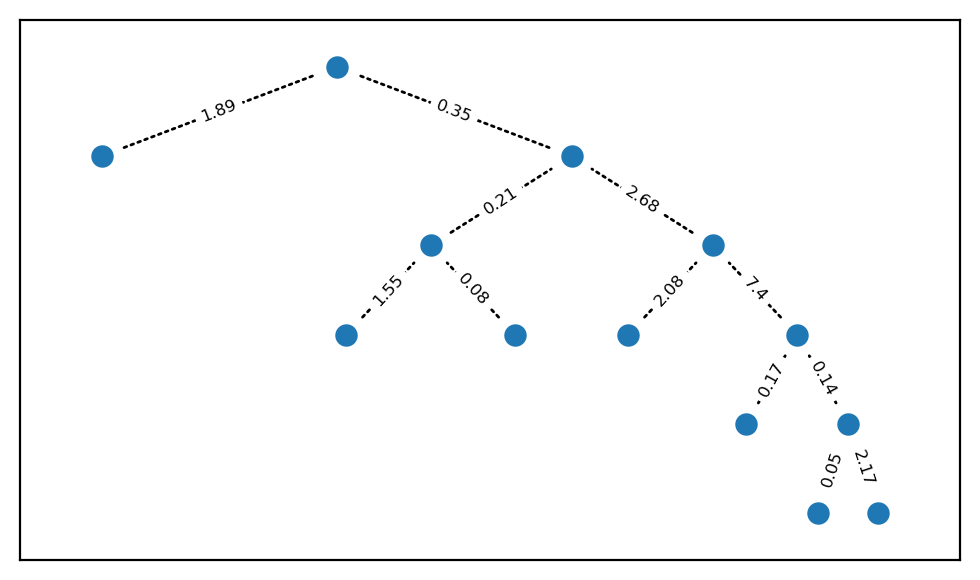

In [426]:
# Generate test tree
test_tree = sample_biased_topology(n_leaves=7, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=5, vocab=DNA_vocab,
                            t_scale=2, seed=1234)
# Visualize original tree
visualize_metric_tree(
    test_G, test_JC_tree[1], node_size=50, 
    dx_decay=0.6, edge_font_size=6)

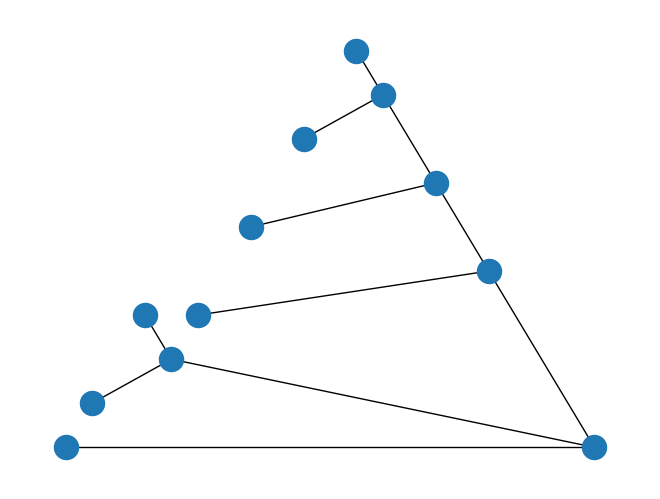

In [466]:
# Remove root and show graph
test_G_unrooted = remove_root(test_G, dist_dict=test_JC_tree[1])
nx.draw_planar(test_G_unrooted)

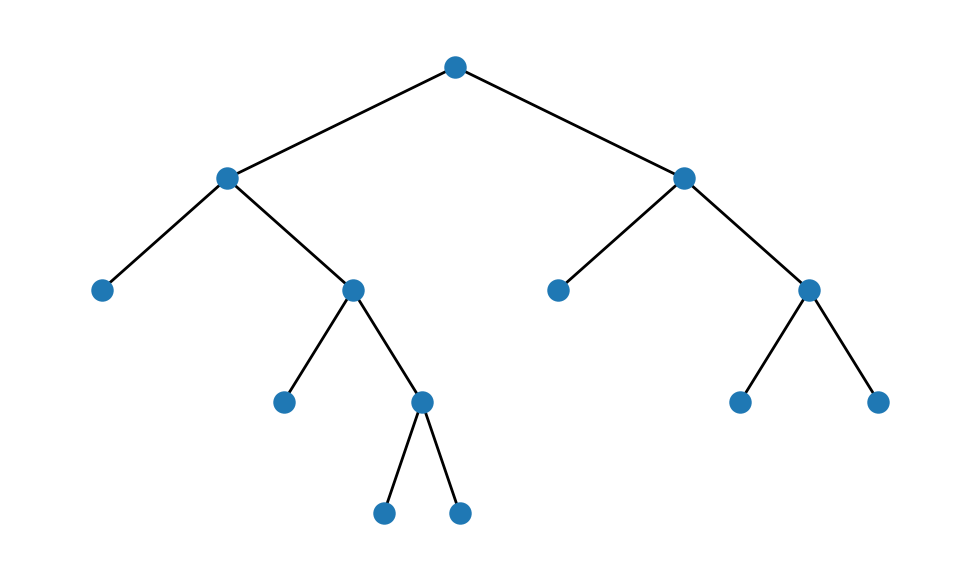

In [469]:
# Re-add root randomly
test_G_random_root = add_root(test_G_unrooted)
visualize_tree(test_G_random_root, node_size=50, dx_decay=0.55)

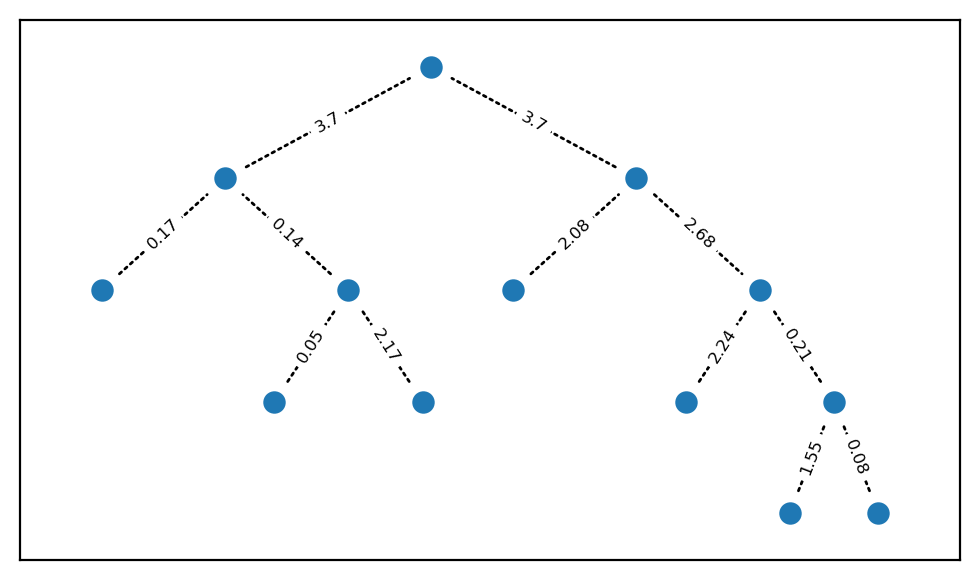

In [472]:
# Re-add root at the longest edge
test_G_long_root, new_dist = add_root(
    test_G_unrooted, 
    dist_dict=nx.get_edge_attributes(test_G_unrooted, 'length')
)
visualize_metric_tree(test_G_long_root, new_dist, node_size=50, 
                      dx_decay=0.6, edge_font_size=6)

### Checking the moves in tree space - NNI

In [475]:
# Generate test tree
test_tree = sample_biased_topology(n_leaves=7, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=5, vocab=DNA_vocab,
                            t_scale=2, seed=1234)

In [532]:
# Get unrooted tree
test_G_unrooted = remove_root(test_G, test_JC_tree[1])

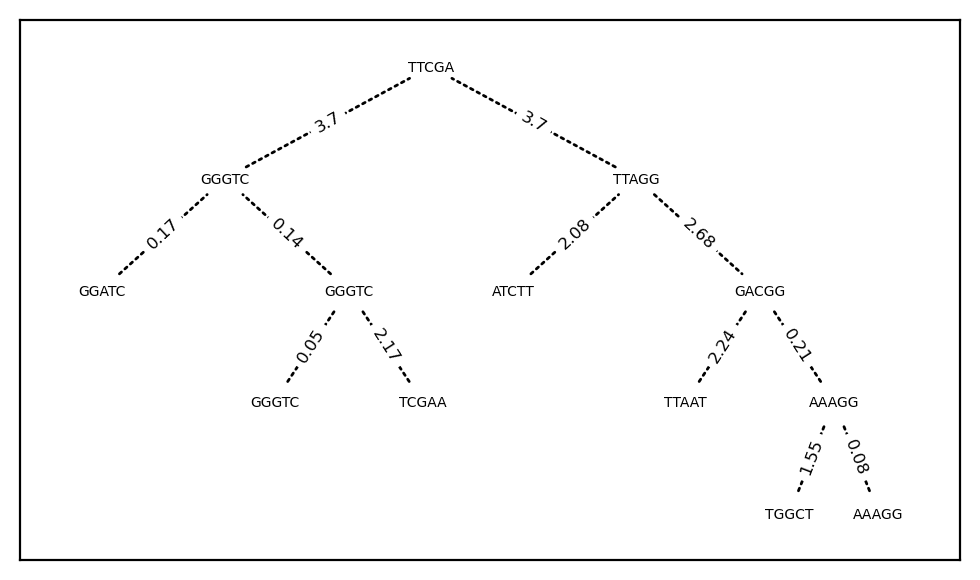

In [540]:
# Visualize original metric tree for rebalanced root
test_G_rebalanced, rebalanced_dist = add_root(
    test_G_unrooted, dist_dict=nx.get_edge_attributes(test_G_unrooted, name='length'))
visualize_phylogenetic_tree(
    test_G_rebalanced, test_JC_tree[0], rebalanced_dist, node_size=0, 
    dx_decay=0.6, edge_font_size=6, node_font_size=5, 
    path='../Figures/test_NNI_move_before.png')

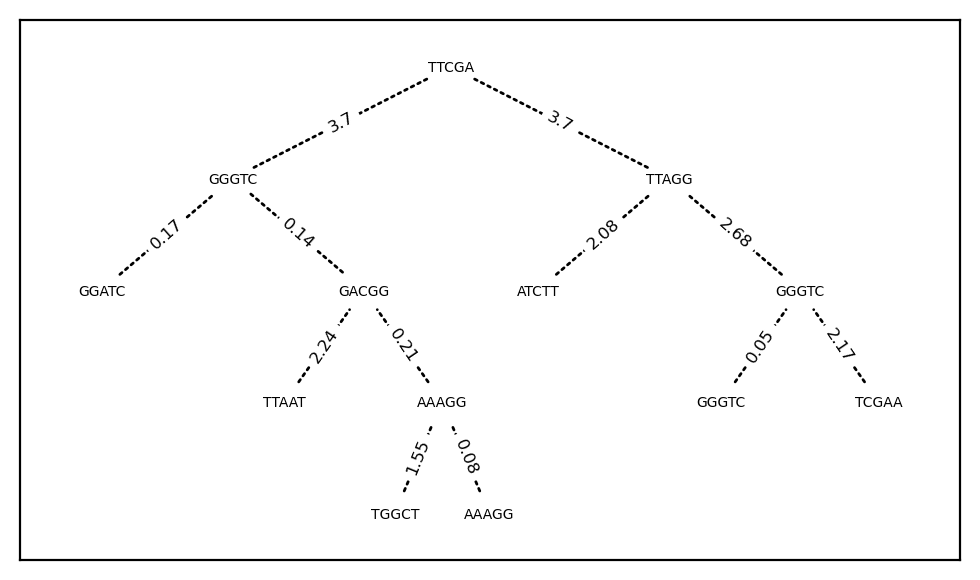

In [545]:
# Perform NNI move
test_G_NNI = NNI_move(test_G_unrooted)
# Add root and visualize
test_G_NNI, NNI_dist = add_root(test_G_NNI, dist_dict=nx.get_edge_attributes(test_G_NNI, name='length'))
visualize_phylogenetic_tree(
    test_G_NNI, test_JC_tree[0], NNI_dist, node_size=0, 
    dx_decay=0.6, edge_font_size=6, node_font_size=5, 
    path='../Figures/test_NNI_move_after.png')

### Checking the moves in tree space - SPR

In [864]:
# Generate test tree
test_tree = sample_biased_topology(n_leaves=9, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=4, vocab=DNA_vocab,
                            t_scale=2, seed=1234)

# Only keep leaf labels
leaf_labels = get_leaf_labels(test_G, test_JC_tree[0])

# Build figure composition labels
comp_labels = dict()
for n in list(test_G.nodes()):
    if n in leaf_labels:
        comp_labels[n] = leaf_labels[n]
    else:
        comp_labels[n] = 'O'

In [865]:
# Get unrooted tree
test_G_unrooted = remove_root(test_G, test_JC_tree[1])

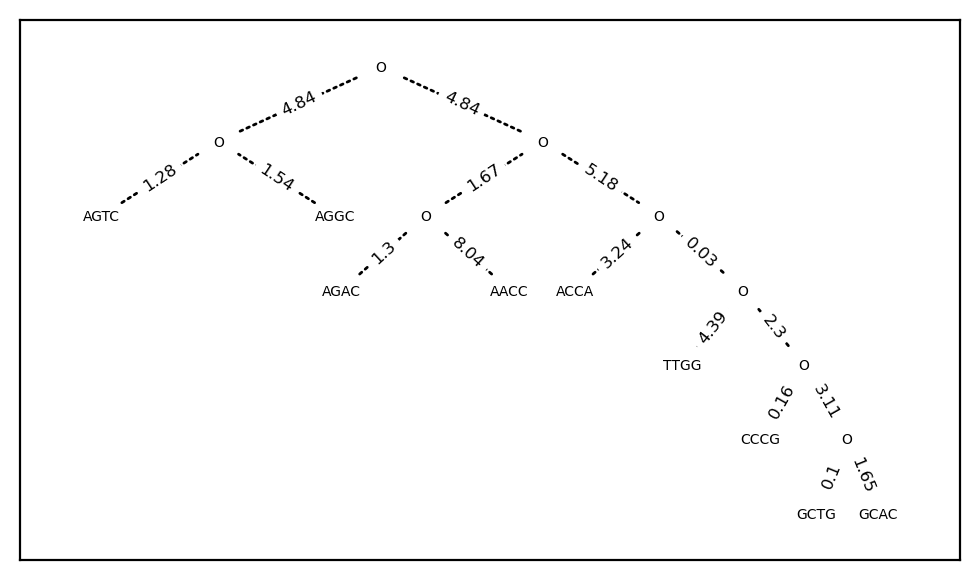

In [866]:
# Visualize original metric tree for rebalanced root
test_G_rebalanced, rebalanced_dist = add_root(
    test_G_unrooted, dist_dict=nx.get_edge_attributes(test_G_unrooted, name='length'))
visualize_phylogenetic_tree(
    test_G_rebalanced, comp_labels, rebalanced_dist, node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/test_SPR_move_before.png')

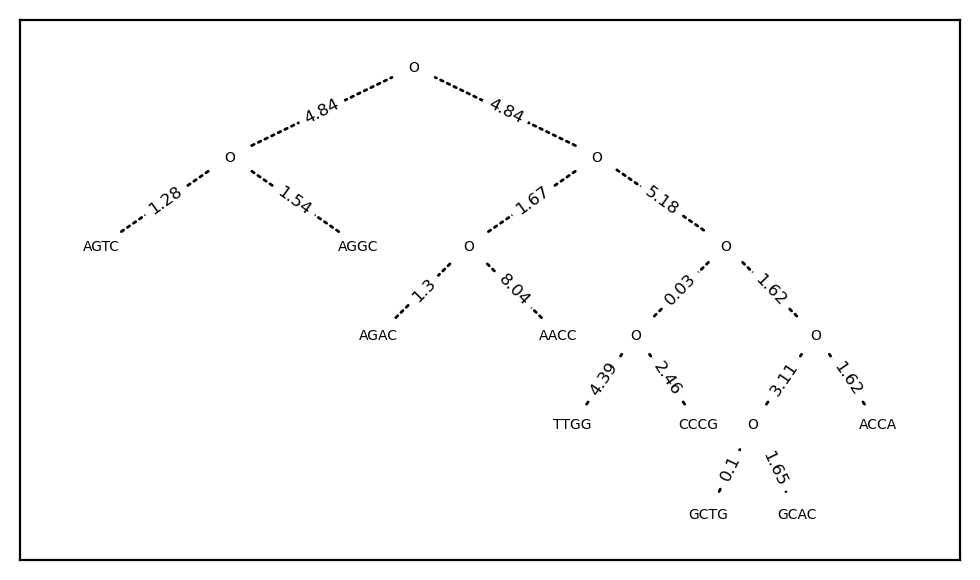

In [870]:
# Perform SPR move
test_G_SPR = SPR_move(test_G_unrooted)
# Add root
test_G_SPR, SPR_dist = add_root(test_G_SPR, dist_dict=nx.get_edge_attributes(test_G_SPR, name='length'))
# Build figure composition labels
comp_labels = dict()
for n in list(test_G_SPR.nodes()):
    if n in leaf_labels:
        comp_labels[n] = leaf_labels[n]
    else:
        comp_labels[n] = 'O'
# Visualize
visualize_phylogenetic_tree(
    test_G_SPR, comp_labels, SPR_dist, node_size=0, 
    dx_decay=0.7, edge_font_size=6, node_font_size=5, 
    path='../Figures/test_SPR_move_after.png')

### Checking the correct functioning of Felsenstein's algorithm

In [785]:
# Generate test tree
test_tree = sample_biased_topology(n_leaves=7, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=5, vocab=DNA_vocab,
                            t_scale=2, seed=1234)

# Only keep leaf labels
leaf_labels = get_leaf_labels(test_G, test_JC_tree[0])

# Build figure composition labels
comp_labels = build_comp_labels(test_G, leaf_labels)

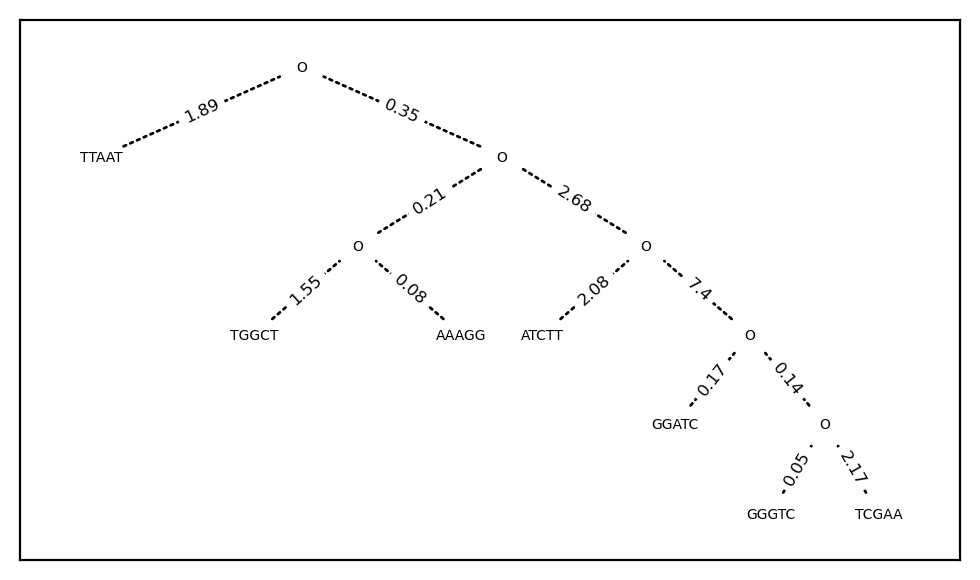

In [786]:
visualize_phylogenetic_tree(
    test_G, comp_labels, test_JC_tree[1], node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5)

In [649]:
log_likelihood_test = get_JC_probability(
    test_G, leaf_labels, test_JC_tree[1],
    alpha=1, vocab=DNA_vocab)
print('Log-likelihood of the original tree:', round(log_likelihood_test, 2))

Log-likelihood of the original tree: -46.04


In [652]:
# Does the log-likelihood change if we reset the root?
test_G_unrooted = remove_root(test_G, test_JC_tree[1])
test_G_rebalanced, rebalanced_dist = add_root(
    test_G_unrooted, dist_dict=nx.get_edge_attributes(test_G_unrooted,
                                                      name='length'))
log_likelihood_rebalanced = get_JC_probability(
    test_G_rebalanced, leaf_labels, rebalanced_dist,
    alpha=1, vocab=DNA_vocab)
print('Log-likelihood of the rebalanced tree:', round(log_likelihood_rebalanced, 2))

Log-likelihood of the rebalanced tree: -46.04


### Checking the correct functioning of our MC steps

In [874]:
# Generate test tree
test_tree = sample_biased_topology(n_leaves=6, seed=1234)
test_G = topology_to_graph(test_tree)
test_JC_tree = draw_JC_tree(test_G, m=6, vocab=DNA_vocab,
                            t_scale=0.3, seed=1234)

# Only keep leaf labels
leaf_labels = get_leaf_labels(test_G, test_JC_tree[0])

# Build figure composition labels
comp_labels = build_comp_labels(test_G, leaf_labels)

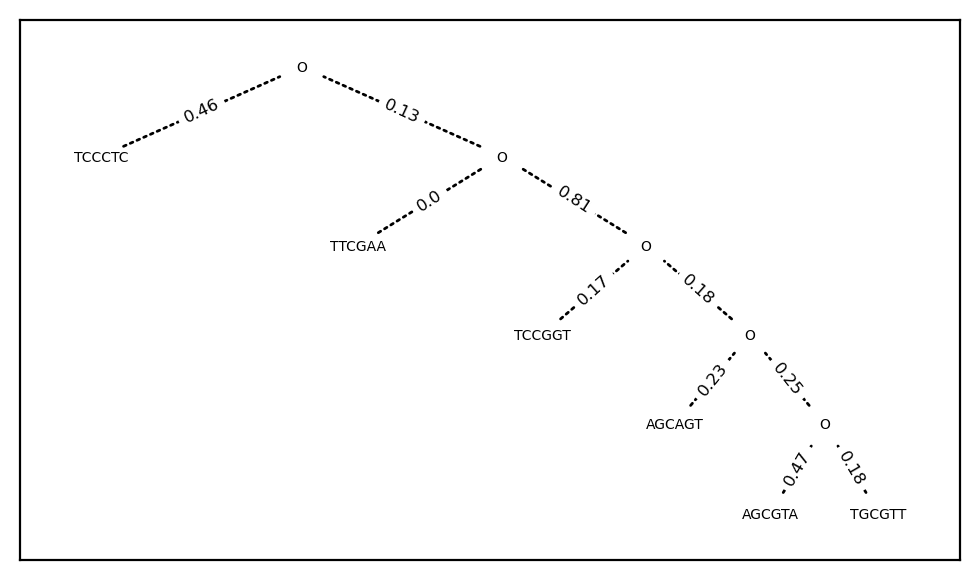

In [875]:
visualize_phylogenetic_tree(
    test_G, comp_labels, test_JC_tree[1], node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5)

In [876]:
# Can we use cherry sets to uniquely map the leaf arrangement of a tree?
test_set = find_cherries(test_G)
test_set

frozenset({1,
           frozenset({2, frozenset({3, frozenset({4, frozenset({5, 6})})})})})

In [877]:
# Define prior weight
t_star = -(3/8) * np.log(2/3)
delta_t = 0.05
lamb = 1 / (t_star + delta_t)

In [878]:
# Assign edge length attribute to the tree
nx.set_edge_attributes(test_G, values=test_JC_tree[1], name='length')

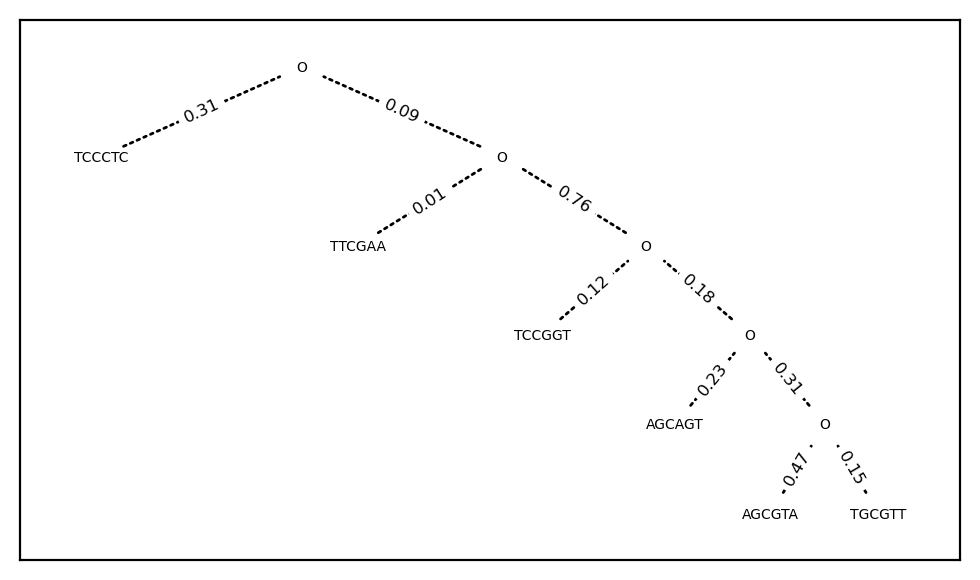

In [879]:
# Perform internal MC step and visualize
int_MC_G, MC_stats = internal_MC_step(test_G, leaf_labels, vocab=DNA_vocab, lamb=lamb)
visualize_phylogenetic_tree(
    int_MC_G, comp_labels, nx.get_edge_attributes(int_MC_G, name='length'), 
    node_size=0, dx_decay=0.72, edge_font_size=6, node_font_size=5)

In [880]:
MC_stats

{'int_acc_ratio': 1.0, 'int_N_accepted': 10, 'int_N_total': 10}

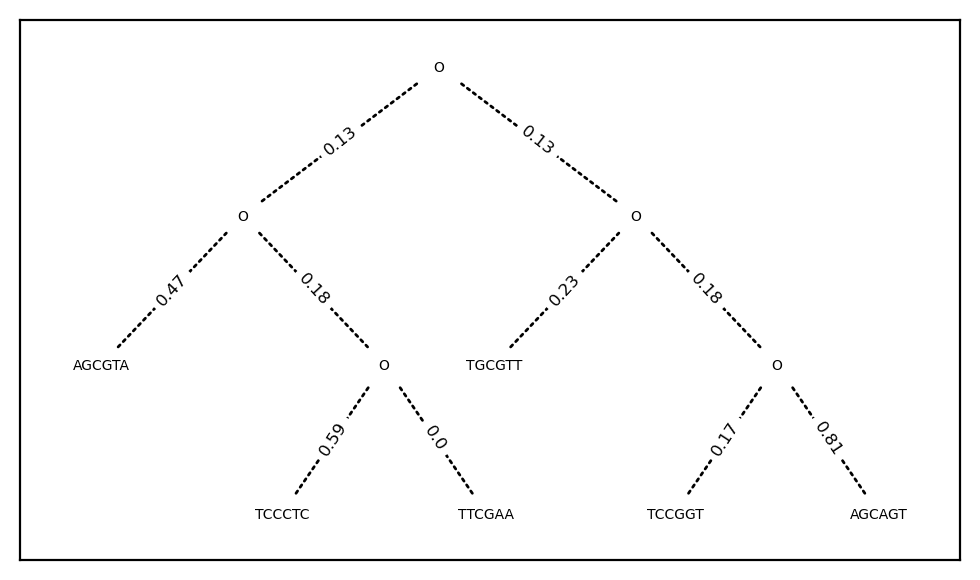

In [885]:
# Perform external MC step and visualize
ext_MC_G, MC_stats = external_MC_step(test_G, leaf_labels, vocab=DNA_vocab)
comp_labels = build_comp_labels(ext_MC_G, leaf_labels)
visualize_phylogenetic_tree(
    ext_MC_G, comp_labels, nx.get_edge_attributes(ext_MC_G, name='length'), 
    node_size=0, dx_decay=0.72, edge_font_size=6, node_font_size=5)

In [886]:
find_cherries(test_G), find_cherries(ext_MC_G)

(frozenset({1,
            frozenset({2,
                       frozenset({3, frozenset({4, frozenset({5, 6})})})})}),
 frozenset({frozenset({5, frozenset({1, 2})}),
            frozenset({6, frozenset({3, 4})})}))

In [887]:
MC_stats

{'ext_acc_ratio': 0.5,
 'ext_acc_ratio_NNI': 0.6666666666666666,
 'ext_acc_ratio_SPR': 0.0,
 'ext_N_accepted_NNI': 2,
 'ext_N_accepted_SPR': 0,
 'ext_N_total_NNI': 3,
 'ext_N_total_SPR': 1}

## Small test: data simulation + inference

### Generating the synthetic data

In [1467]:
# Define a vocabulary for testing
DNA_vocab = {'A': 0, 'G': 1, 'C': 2, 'T': 3}

# Define edge length scale for simulation and inference
t_star = -(3/8) * np.log(2/3)
delta_t = 0.05
lamb_t = float(1 / (t_star + delta_t))

# Generate synthetic data
synth_seed = 1231
synth_tree = sample_biased_topology(n_leaves=6, seed=synth_seed)
synth_G = topology_to_graph(synth_tree)
synth_JC_tree = draw_JC_tree(synth_G, m=6, vocab=DNA_vocab,
                            t_scale=1/lamb_t, seed=synth_seed)

# Only keep leaf labels
leaf_labels = get_leaf_labels(synth_G, synth_JC_tree[0])

# Build figure composition labels
comp_labels = build_comp_labels(synth_G, leaf_labels)

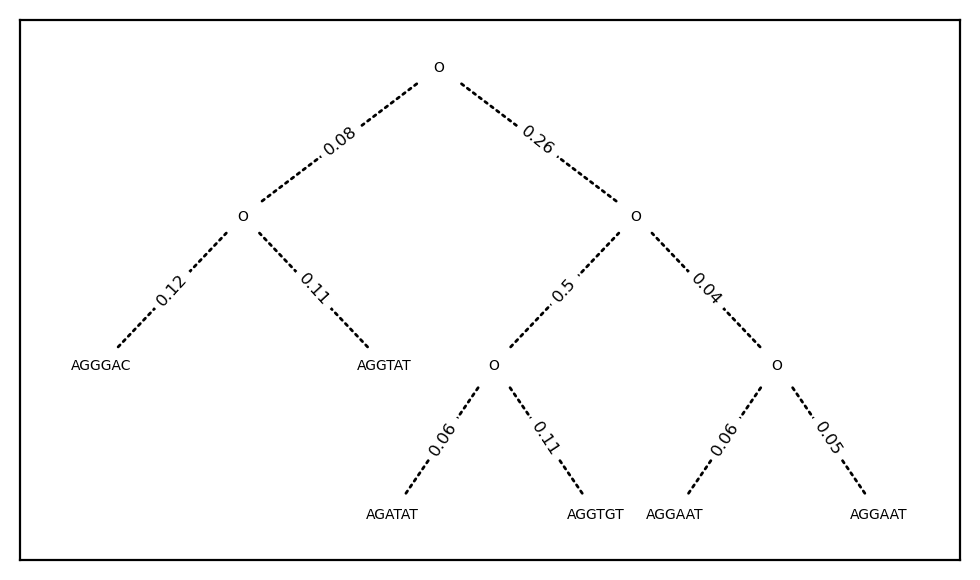

In [1468]:
visualize_phylogenetic_tree(
    synth_G, comp_labels, synth_JC_tree[1], node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/pipeline_test_synth_tree_n_6_m_6.png')

In [1469]:
# Save original graph and leaf labels
nx.set_edge_attributes(synth_G, synth_JC_tree[1], name='length')
nx.set_node_attributes(synth_G, synth_JC_tree[0], name='sequence')
nx.write_gml(synth_G, path='./small_test_n_6_m_6/synth_tree')

In [1470]:
# This is how to read a file and set the tree node labels properly
synth_G = nx.read_gml(path='./small_test_n_6_m_6/synth_tree')
old_labels = list(synth_G.nodes)
synth_G = nx.relabel_nodes(synth_G, mapping={n:int(n) for n in old_labels})

### Performing MCMC inference

In [1471]:
# Now let us test the inference pipeline
synth_seqs = [leaf_labels[n] for n in leaf_labels]
run_inference(
    synth_seqs, path='./small_test_n_6_m_6/', burnin_steps=500, sampling_steps=20000, 
    vocab=DNA_vocab, lamb_t=lamb_t, seed=synth_seed+1, gamma_0=2.5, N_SPR=2)

Initializing tree graph
Performing burn-in stage
Performing sampling stage


/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))


Elapsed time: 100.29 s


### Performance analysis

In [1472]:
# Read our stats
burnin_stats = pd.read_csv('./small_test_n_6_m_6/burnin_stats.csv')
sampling_stats = pd.read_csv('./small_test_n_6_m_6/sampling_stats.csv')

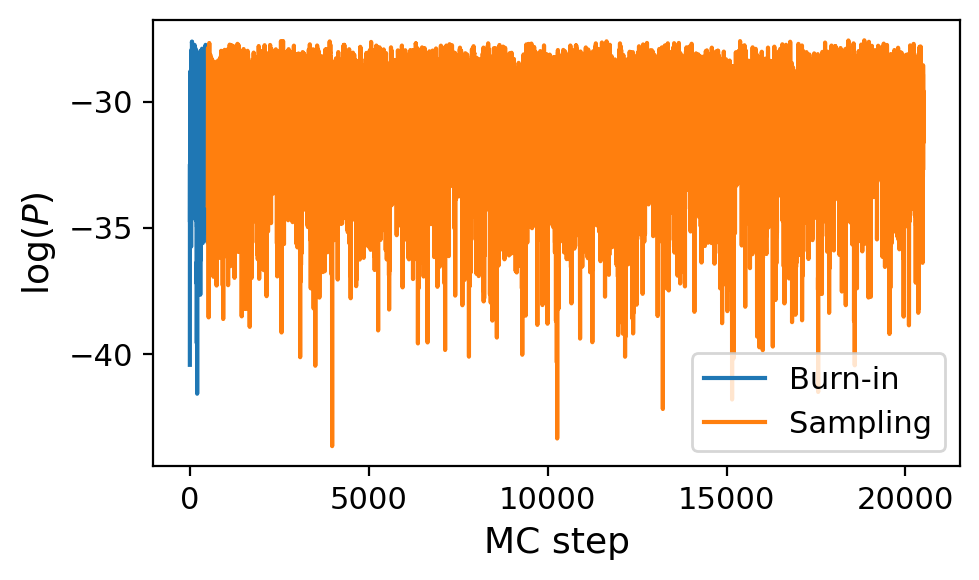

In [1473]:
# Plot posterior during burn-in and sampling:
plot_stat(burnin_stats, sampling_stats, 'log_P', r'$\log(P)$', 
          path='../Figures/pipeline_test_log_P_vs_MC_step.png')

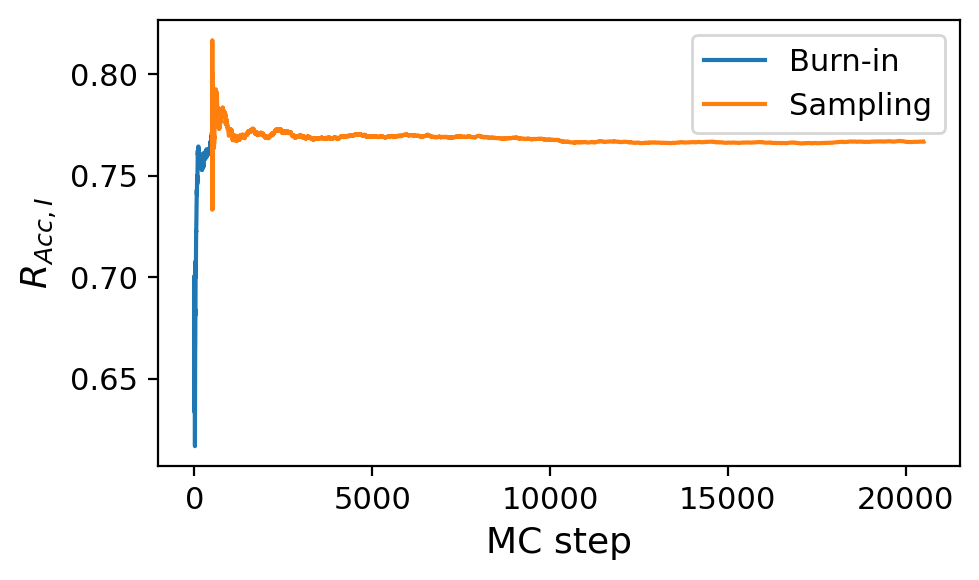

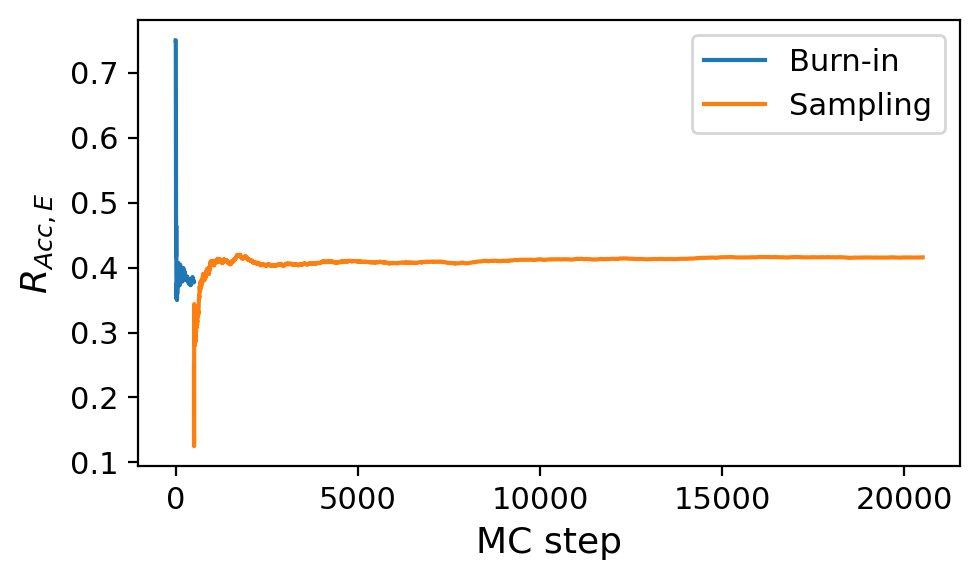

In [1474]:
# Define cumulative acceptance ratios
f_int = lambda x: np.cumsum(x['int_N_accepted']) / np.cumsum(x['int_N_total'])
burnin_stats['tot_int_acc_ratio'] = f_int(burnin_stats)
sampling_stats['tot_int_acc_ratio'] = f_int(sampling_stats)

f_ext = lambda x: np.cumsum(x['ext_N_accepted_NNI'] + x['ext_N_accepted_SPR'])\
                    / np.cumsum(x['ext_N_total_NNI'] + x['ext_N_total_SPR'])
burnin_stats['tot_ext_acc_ratio'] = f_ext(burnin_stats)
sampling_stats['tot_ext_acc_ratio'] = f_ext(sampling_stats)
# Plot acceptance ratios:
plot_stat(burnin_stats, sampling_stats, 'tot_int_acc_ratio', r'$R_{Acc,I}$', 
         path='../Figures/pipeline_test_R_acc_I_vs_MC_step.png')
plot_stat(burnin_stats, sampling_stats, 'tot_ext_acc_ratio', r'$R_{Acc,E}$', 
         path='../Figures/pipeline_test_R_acc_E_vs_MC_step.png')

### Result analysis

In [1475]:
# Read our unique topologies
unique_tops = pd.read_csv('./small_test_n_6_m_6/unique_topologies.csv', index_col='Unnamed: 0').transpose()
unique_tops['counts'] = unique_tops['log_P'].apply(lambda x: len(eval(x)))
unique_tops['max_log_P'] = unique_tops['log_P'].apply(lambda x: np.max(eval(x)))

In [1478]:
# Read our leaf labels from inference
leaf_labels_df = pd.read_csv('./small_test_n_6_m_6/leaf_labels.csv')
leaf_labels_inf = dict()
for i in range(leaf_labels_df.shape[0]):
    node_id = int(leaf_labels_df['node'].iloc[i])
    leaf_labels_inf[node_id] = leaf_labels_df['sequence'].iloc[i]

In [1479]:
# Find MAP tree
max_P = unique_tops['max_log_P'].max()
MAP_tree_file = unique_tops.loc[unique_tops['max_log_P'] == max_P, 'file'].iloc[0]
MAP_G = nx.read_gml(path=MAP_tree_file)
old_labels = list(MAP_G.nodes)
MAP_G = nx.relabel_nodes(MAP_G, mapping={n:int(n) for n in old_labels})

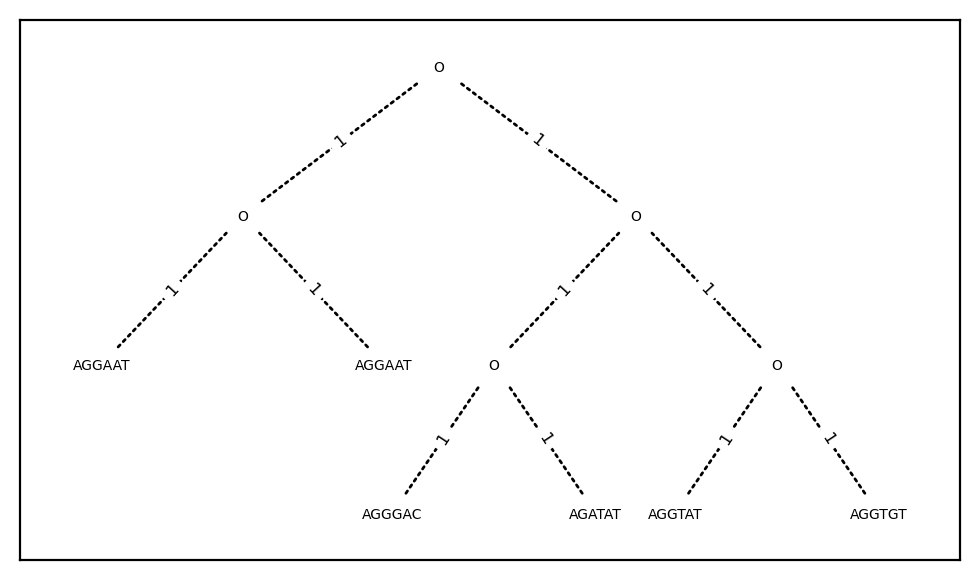

In [1480]:
# Visualize MAP
comp_labels = build_comp_labels(MAP_G, leaf_labels_inf)
comp_edges = {n: 1 for n in MAP_G.edges}
visualize_phylogenetic_tree(
    MAP_G, comp_labels, comp_edges, node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/pipeline_test_MAP_tree_n_6_m_6.png')

In [1481]:
# Get the split consensus for the sampled topologies
all_trees = []
for f in unique_tops['file']:
    # Read tree and relabel nodes
    tree = nx.read_gml(path=f)
    old_labels = list(tree.nodes)
    tree = nx.relabel_nodes(tree, mapping={n:int(n) for n in old_labels})

    # Save tree
    all_trees.append(tree)
    
all_weigths = list(unique_tops['counts'])
all_splits = split_consensus(all_trees, all_weigths)
all_splits

{((8, 7), (1, 2, 4, 5)): 0.24975,
 ((1, 4), (8, 2, 5, 7)): 0.153,
 ((2, 5), (8, 1, 4, 7)): 0.0133,
 ((1, 4, 5), (8, 2, 7)): 0.00905,
 ((1, 2), (8, 4, 5, 7)): 0.1577,
 ((1, 2, 5), (8, 4, 7)): 0.00895,
 ((1, 5), (8, 2, 4, 7)): 0.1599,
 ((2, 4), (8, 1, 5, 7)): 0.62125,
 ((2, 4, 7), (8, 1, 5)): 0.1379,
 ((8, 5, 7), (1, 2, 4)): 0.44945,
 ((5, 7), (8, 1, 2, 4)): 0.24145,
 ((8, 5), (1, 2, 4, 7)): 0.23185,
 ((1, 7), (8, 2, 4, 5)): 0.09905,
 ((1, 5, 7), (8, 2, 4)): 0.1107,
 ((8, 1), (2, 4, 5, 7)): 0.16315,
 ((8, 1, 7), (2, 4, 5)): 0.1116,
 ((1, 4, 7), (8, 2, 5)): 0.0055,
 ((4, 5, 7), (8, 1, 2)): 0.0099,
 ((8, 1, 4), (2, 5, 7)): 0.0089,
 ((8, 2), (1, 4, 5, 7)): 0.01355,
 ((4, 7), (8, 1, 2, 5)): 0.00545,
 ((4, 5), (8, 1, 2, 7)): 0.01365,
 ((8, 4), (1, 2, 5, 7)): 0.0142,
 ((8, 4, 5), (1, 2, 7)): 0.0056,
 ((2, 7), (8, 1, 4, 5)): 0.0052}

In [1491]:
# Compare split consensus with original splits
og_split = split_consensus([synth_G], [1])
og_split_seqs = dict()
for s in og_split:
    # Reformat key
    new_s = list(str(s))
    for i, c in enumerate(new_s):
        if c in [str(lf) for lf in leaf_labels]:
            new_s[i] = leaf_labels[int(c)]
    new_s = ''.join(new_s)

    # Register key-value pair
    og_split_seqs[new_s] = og_split[s]
    
print('Original split:')
print(og_split_seqs)

majority_consensus = {s:all_splits[s] for s in all_splits if all_splits[s] > 0.5}
majority_consensus_seqs = dict()
for s in majority_consensus:
    # Reformat key
    new_s = list(str(s))
    for i, c in enumerate(new_s):
        if c in [str(lf) for lf in leaf_labels_inf]:
            new_s[i] = leaf_labels_inf[int(c)]
    new_s = ''.join(new_s)

    # Register key-value pair
    majority_consensus_seqs[new_s] = majority_consensus[s]
print('Majority-rule consensus:')
print(majority_consensus_seqs)

Original split:
{'((AGGGAC, AGGTAT), (AGGAAT, AGATAT, AGGTGT, AGGAAT))': 1.0, '((AGATAT, AGGTGT), (AGGAAT, AGGGAC, AGGTAT, AGGAAT))': 1.0, '((AGGAAT, AGGAAT), (AGGGAC, AGGTAT, AGATAT, AGGTGT))': 1.0}
Majority-rule consensus:
{'((AGGAAT, AGGAAT), (AGGTGT, AGGGAC, AGATAT, AGGTAT))': 0.62125}


In [1492]:
# What does the consensus split look like:
for s in majority_consensus:
    leaf_1 = [leaf_labels_inf[l] for l in s[0]]
    leaf_2 = [leaf_labels_inf[l] for l in s[1]]
    print(f"{s[0]} -> {leaf_1}, HD = {total_Hamming_distance(leaf_1)}")
    print(f"{s[1]} -> {leaf_2}, HD = {total_Hamming_distance(leaf_2)}")

(2, 4) -> ['AGGAAT', 'AGGAAT'], HD = 0.0
(8, 1, 5, 7) -> ['AGGTGT', 'AGGGAC', 'AGATAT', 'AGGTAT'], HD = 0.3333333333333333


In [1493]:
# How does this compare to the original splits?
for s in og_split:
    leaf_1 = [leaf_labels[l] for l in s[0]]
    leaf_2 = [leaf_labels[l] for l in s[1]]
    print(f"{s[0]} -> {leaf_1}, HD = {total_Hamming_distance(leaf_1)}")
    print(f"{s[1]} -> {leaf_2}, HD = {total_Hamming_distance(leaf_2)}\n")

(1, 2) -> ['AGGGAC', 'AGGTAT'], HD = 0.3333333333333333
(8, 4, 5, 7) -> ['AGGAAT', 'AGATAT', 'AGGTGT', 'AGGAAT'], HD = 0.27777777777777773

(4, 5) -> ['AGATAT', 'AGGTGT'], HD = 0.3333333333333333
(8, 1, 2, 7) -> ['AGGAAT', 'AGGGAC', 'AGGTAT', 'AGGAAT'], HD = 0.2222222222222222

(8, 7) -> ['AGGAAT', 'AGGAAT'], HD = 0.0
(1, 2, 4, 5) -> ['AGGGAC', 'AGGTAT', 'AGATAT', 'AGGTGT'], HD = 0.3333333333333333



In [1494]:
# How does the original tree rank in terms of posterior compared to
# the sampled trees?
og_log_posterior = float(log_posterior_JC(synth_G, leaf_labels, lamb_t, DNA_vocab))
sorted_log_P = np.array(sorted(unique_tops['max_log_P'], reverse=True))
og_position = int(np.argmax(og_log_posterior > sorted_log_P)) + 1

print(f'Rank of the original tree based on log-posterior: {og_position} out of {unique_tops.shape[0]}')

Rank of the original tree based on log-posterior: 259 out of 267


Despite the original sequences and topology being generated from the Jukes-Cantor process, there are many topologies that are far more likely with respect to the data. This is not unexpected, since for each sequence we effectively have only 6 "samples" of the JC process. The synthetic tree could be more representative of the actual optimal topology if the sequences were longer.

In [1495]:
# Now, let us sample the edge length distributions in the MAP tree
edge_samples, burnin_stats_edges, sampling_stats_edges = sample_edge_lengths(
    MAP_G, burnin_steps=3000, sampling_steps=5000, leaf_labels=leaf_labels_inf, 
    vocab=DNA_vocab, lamb=lamb_t, seed=synth_seed+1, gamma_0=1)

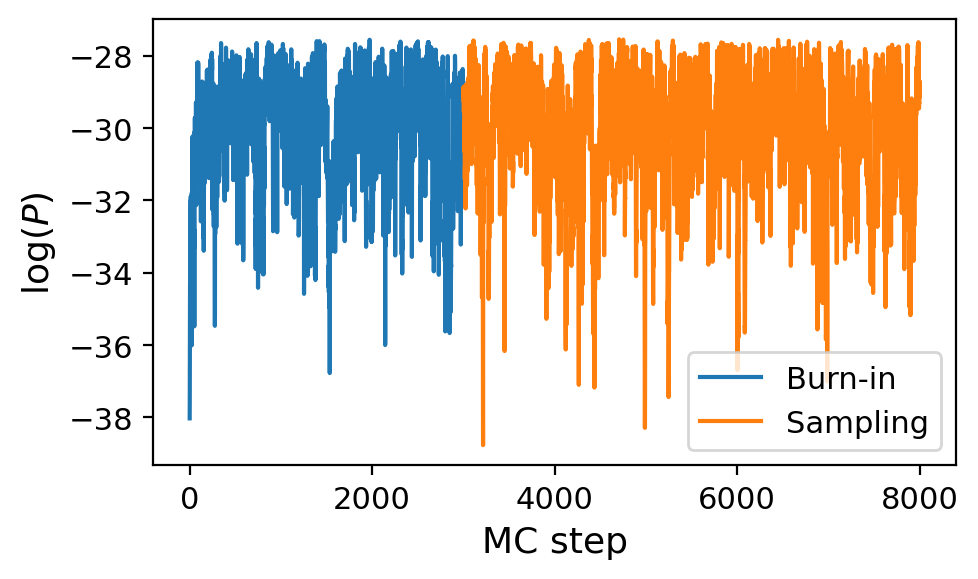

In [1496]:
plot_stat(burnin_stats_edges, sampling_stats_edges, stat_name='log_P', stat_label=r'$\log(P)$',
         path='../Figures/pipeline_test_edges_log_P_vs_MC_step.png')

In [1497]:
# Take 1 every 10 samples, to reduce the correlation
edge_samples_nocorr = dict()
for e in edge_samples:
    edge_samples_nocorr[e] = np.array(edge_samples[e])[::10]

In [1498]:
# Now we can estimate the mean and std for each edge
edge_stats = dict()
for e in edge_samples_nocorr:
    samples_e = edge_samples_nocorr[e]
    mean_e = round(np.mean(samples_e), 2)
    std_e = round(np.std(samples_e), 3)
    edge_stats[e] = str(mean_e) + '±' + str(std_e)

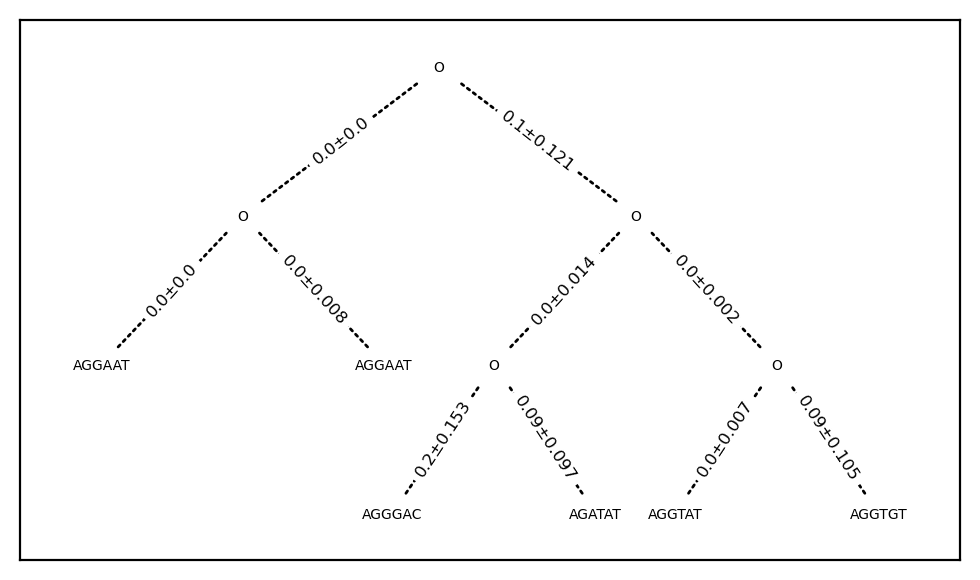

In [1499]:
# Finally, we can plot the MAP with the Bayesian estimated edge lengths
comp_labels = build_comp_labels(MAP_G, leaf_labels_inf)
visualize_phylogenetic_tree_Bayes(
    MAP_G, comp_labels, edge_stats, node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/pipeline_test_MAP_Bayes_edges_tree_n_6_m_6.png')

# Case study: $N = 10$, $M = 10$

## Generating the synthetic data

In [1500]:
# Define a vocabulary for testing
DNA_vocab = {'A': 0, 'G': 1, 'C': 2, 'T': 3}

# Define edge length scale for simulation and inference
t_star = -(3/8) * np.log(2/3)
delta_t = 0.01
lamb_t = float(1 / (t_star + delta_t))

# Generate synthetic data
synth_seed = 1234
synth_tree = sample_biased_topology(n_leaves=10, seed=synth_seed)
synth_G = topology_to_graph(synth_tree)
synth_JC_tree = draw_JC_tree(synth_G, m=10, vocab=DNA_vocab,
                            t_scale=1/lamb_t, seed=synth_seed)

# Only keep leaf labels
leaf_labels = get_leaf_labels(synth_G, synth_JC_tree[0])

# Build figure composition labels
comp_labels = build_comp_labels(synth_G, leaf_labels)

# Adapt composition labels for plot
comp_labels[11] = '\n\n' + comp_labels[11]
comp_labels[14] = '\n\n' + comp_labels[14]

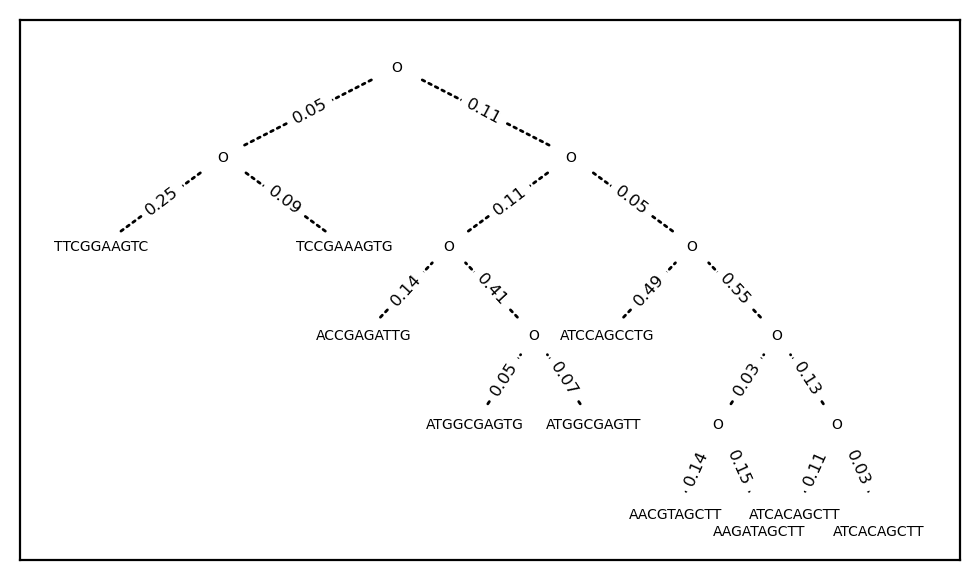

In [1501]:
visualize_phylogenetic_tree(
    synth_G, comp_labels, synth_JC_tree[1], node_size=0, 
    dx_decay=0.7, edge_font_size=6, node_font_size=5, 
    path='../Figures/case_study_small_synth_tree_n_10_m_10.png')

In [1502]:
# Save original graph and leaf labels
nx.set_edge_attributes(synth_G, synth_JC_tree[1], name='length')
nx.set_node_attributes(synth_G, synth_JC_tree[0], name='sequence')
nx.write_gml(synth_G, path='./case_study_n_10_m_10/synth_tree')

In [1503]:
# This is how to read a file and set the tree node labels properly
synth_G = nx.read_gml(path='./case_study_n_10_m_10/synth_tree')
old_labels = list(synth_G.nodes)
synth_G = nx.relabel_nodes(synth_G, mapping={n:int(n) for n in old_labels})

## Performing MCMC inference

In [1504]:
# Now let us run the inference pipeline
synth_seqs = [leaf_labels[n] for n in leaf_labels]
run_inference(
    synth_seqs, path='./case_study_n_10_m_10/', burnin_steps=500, sampling_steps=20000, 
    vocab=DNA_vocab, lamb_t=lamb_t, seed=synth_seed+1, gamma_0=1., N_SPR=1)

Initializing tree graph
Performing burn-in stage
Performing sampling stage


/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(p_final))
/var/folders/hg/lp447vps5ms9jhjnwcnznskm0000gn/T/ipykernel_21402/3698854553.py:118: RuntimeWarning: divide by zero 

Elapsed time: 286.46 s


## Performance analysis

In [1505]:
# Read our stats
burnin_stats = pd.read_csv('./case_study_n_10_m_10/burnin_stats.csv')
sampling_stats = pd.read_csv('./case_study_n_10_m_10/sampling_stats.csv')

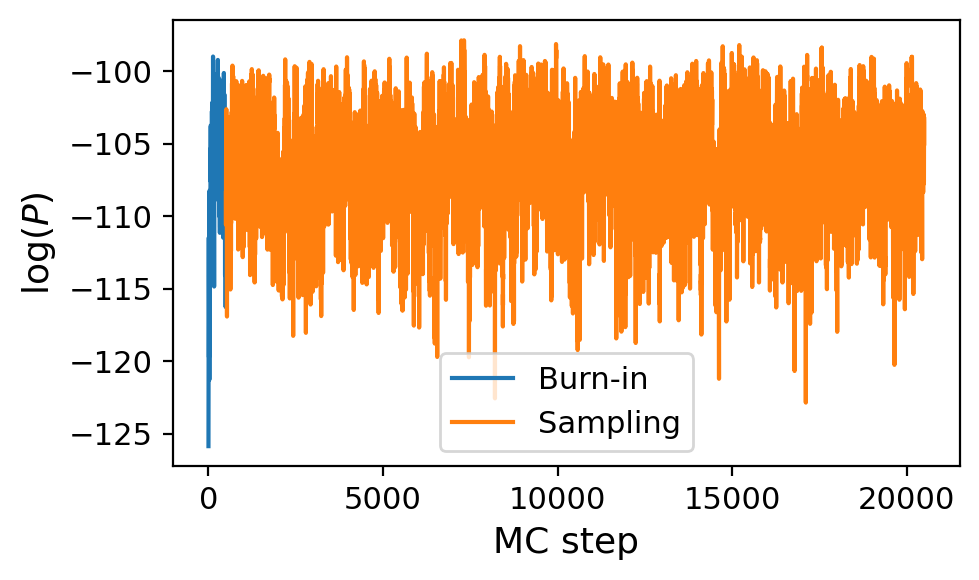

In [1506]:
# Plot posterior during burn-in and sampling:
plot_stat(burnin_stats, sampling_stats, 'log_P', r'$\log(P)$', 
          path='../Figures/case_study_small_log_P_vs_MC_step.png')

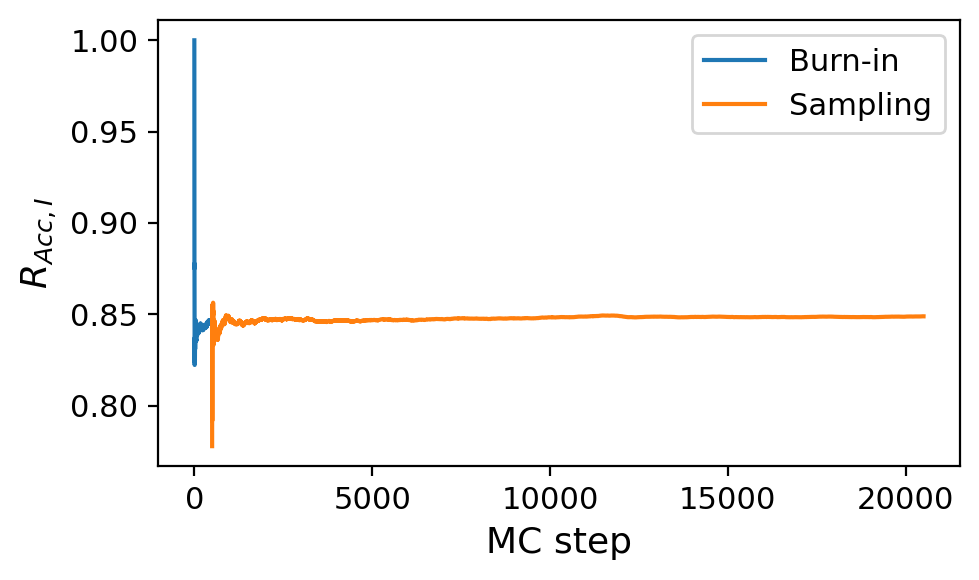

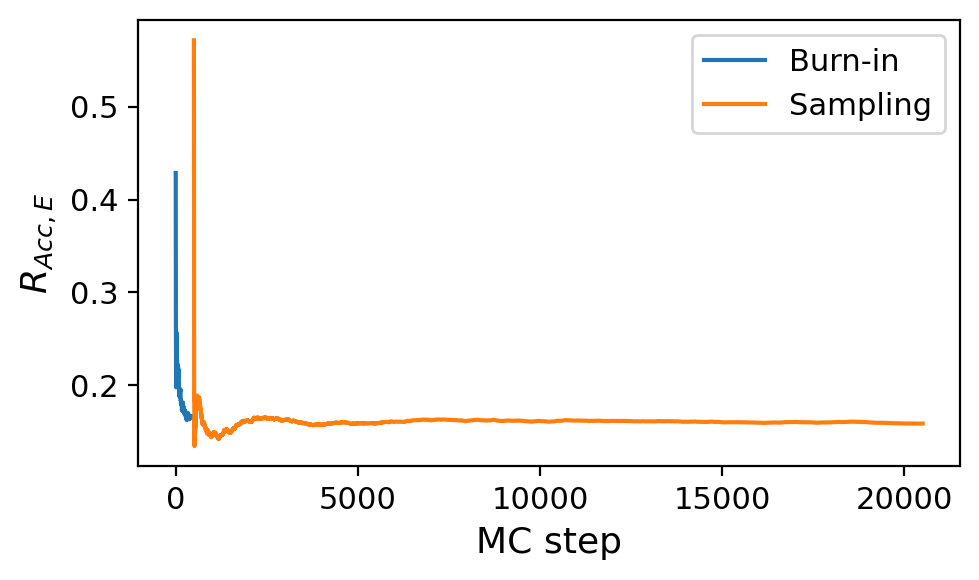

In [1507]:
# Define cumulative acceptance ratios
f_int = lambda x: np.cumsum(x['int_N_accepted']) / np.cumsum(x['int_N_total'])
burnin_stats['tot_int_acc_ratio'] = f_int(burnin_stats)
sampling_stats['tot_int_acc_ratio'] = f_int(sampling_stats)

f_ext = lambda x: np.cumsum(x['ext_N_accepted_NNI'] + x['ext_N_accepted_SPR'])\
                    / np.cumsum(x['ext_N_total_NNI'] + x['ext_N_total_SPR'])
burnin_stats['tot_ext_acc_ratio'] = f_ext(burnin_stats)
sampling_stats['tot_ext_acc_ratio'] = f_ext(sampling_stats)
# Plot acceptance ratios:
plot_stat(burnin_stats, sampling_stats, 'tot_int_acc_ratio', r'$R_{Acc,I}$', 
         path='../Figures/case_study_small_R_acc_I_vs_MC_step.png')
plot_stat(burnin_stats, sampling_stats, 'tot_ext_acc_ratio', r'$R_{Acc,E}$', 
         path='../Figures/case_study_small_R_acc_E_vs_MC_step.png')

## Result analysis

In [1508]:
# Read our unique topologies
unique_tops = pd.read_csv('./case_study_n_10_m_10/unique_topologies.csv', index_col='Unnamed: 0').transpose()
unique_tops['counts'] = unique_tops['log_P'].apply(lambda x: len(eval(x)))
unique_tops['max_log_P'] = unique_tops['log_P'].apply(lambda x: np.max(eval(x)))

In [1509]:
# Find MAP tree
max_P = unique_tops['max_log_P'].max()
MAP_tree_file = unique_tops.loc[unique_tops['max_log_P'] == max_P, 'file'].iloc[0]
MAP_G = nx.read_gml(path=MAP_tree_file)
old_labels = list(MAP_G.nodes)
MAP_G = nx.relabel_nodes(MAP_G, mapping={n:int(n) for n in old_labels})

In [1510]:
# Read our leaf labels from inference
leaf_labels_df = pd.read_csv('./case_study_n_10_m_10/leaf_labels.csv')
leaf_labels_inf = dict()
for i in range(leaf_labels_df.shape[0]):
    node_id = int(leaf_labels_df['node'].iloc[i])
    leaf_labels_inf[node_id] = leaf_labels_df['sequence'].iloc[i]

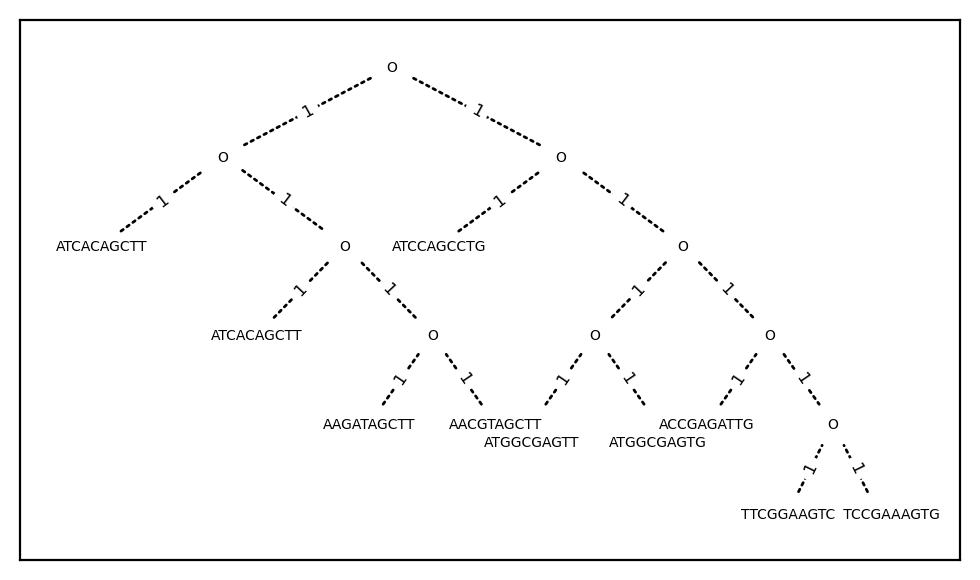

In [1521]:
# Composition labels
comp_labels = build_comp_labels(MAP_G, leaf_labels_inf)
comp_labels[6] = '      ' + comp_labels[6]
comp_labels[10] = '\n\n' + comp_labels[10]
comp_labels[14] = '\n\n' + comp_labels[14]

# Composition edges
comp_edges = {n: 1 for n in MAP_G.edges}
# Visualize MAP
visualize_phylogenetic_tree(
    MAP_G, comp_labels, comp_edges, node_size=0, 
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/case_study_small_MAP_tree_n_10_m_10.png')

In [1523]:
# Get the split consensus for the sampled topologies
all_trees = []
for f in unique_tops['file']:
    # Read tree and relabel nodes
    tree = nx.read_gml(path=f)
    old_labels = list(tree.nodes)
    tree = nx.relabel_nodes(tree, mapping={n:int(n) for n in old_labels})

    # Save tree
    all_trees.append(tree)
    
all_weigths = list(unique_tops['counts'])
all_splits = split_consensus(all_trees, all_weigths)

In [1550]:
# Compare split consensus with original splits
og_split = split_consensus([synth_G], [1])
og_split_seqs = dict()
for s in og_split:
    # Reformat key
    new_s = str(s).split()
    for i, c in enumerate(new_s):
        c_num = c.replace('(', '')
        c_num = c_num.replace(')', '')
        c_num = c_num.replace(',', '')
        if c_num in [str(lf) for lf in leaf_labels]:
            new_s[i] = c.replace(c_num, '"'+leaf_labels[int(c_num)]+'"')
    new_s = ''.join(new_s)

    # Register key-value pair
    og_split_seqs[new_s] = og_split[s]
    
print('Original split:')
for s in og_split_seqs:
    print(f"{s}: {og_split_seqs[s]}")

majority_consensus = {s:all_splits[s] for s in all_splits if all_splits[s] > 0.5}
majority_consensus_seqs = dict()
for s in majority_consensus:
    # Reformat key
    new_s = str(s).split()
    for i, c in enumerate(new_s):
        c_num = c.replace('(', '')
        c_num = c_num.replace(')', '')
        c_num = c_num.replace(',', '')
        if c_num in [str(lf) for lf in leaf_labels_inf]:
            new_s[i] = c.replace(c_num, '"'+leaf_labels_inf[int(c_num)]+'"')
    new_s = ''.join(new_s)

    # Register key-value pair
    majority_consensus_seqs[new_s] = majority_consensus[s]
    
print('Majority-rule consensus:')
for s in majority_consensus_seqs:
    print(f"{s}: {majority_consensus_seqs[s]}")

Original split:
(("TTCGGAAGTC","TCCGAAAGTG"),("ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT","ATCCAGCCTG","AACGTAGCTT","AAGATAGCTT","ATCACAGCTT","ATCACAGCTT")): 1.0
(("ATGGCGAGTG","ATGGCGAGTT"),("TTCGGAAGTC","TCCGAAAGTG","ACCGAGATTG","ATCCAGCCTG","AACGTAGCTT","AAGATAGCTT","ATCACAGCTT","ATCACAGCTT")): 1.0
(("ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT"),("TTCGGAAGTC","TCCGAAAGTG","ATCCAGCCTG","AACGTAGCTT","AAGATAGCTT","ATCACAGCTT","ATCACAGCTT")): 1.0
(("AACGTAGCTT","AAGATAGCTT"),("TTCGGAAGTC","TCCGAAAGTG","ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT","ATCCAGCCTG","ATCACAGCTT","ATCACAGCTT")): 1.0
(("ATCACAGCTT","ATCACAGCTT"),("TTCGGAAGTC","TCCGAAAGTG","ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT","ATCCAGCCTG","AACGTAGCTT","AAGATAGCTT")): 1.0
(("AACGTAGCTT","AAGATAGCTT","ATCACAGCTT","ATCACAGCTT"),("TTCGGAAGTC","TCCGAAAGTG","ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT","ATCCAGCCTG")): 1.0
(("TTCGGAAGTC","TCCGAAAGTG","ACCGAGATTG","ATGGCGAGTG","ATGGCGAGTT"),("ATCCAGCCTG","AACGTAGCTT","AAGATAGCTT","ATCACAGCTT","ATCACAGCTT")): 1

In [1552]:
# Finding similar splits by visual inspection is too difficult in this case, 
# so we may use frozenset representations to do so
og_split_seqs_frozen = []
for s in og_split_seqs:
    frozen_s = []
    for c in eval(s):
        frozen_s.append(frozenset(c))
    frozen_s = frozenset(tuple(frozen_s))
    og_split_seqs_frozen.append(frozen_s)

majority_consensus_seqs_frozen = []
for s in majority_consensus_seqs:
    frozen_s = []
    for c in eval(s):
        frozen_s.append(frozenset(c))
    frozen_s = frozenset(tuple(frozen_s))
    majority_consensus_seqs_frozen.append(frozen_s)

In [1561]:
# Find common splits between the synthetic data and the inference
print('Common splits:')
n_common = 0
for s1 in majority_consensus_seqs_frozen:
    for s2 in og_split_seqs_frozen:
        if s1 == s2:
            n_common += 1
            # Reformat and print
            s = str(s1).replace('frozenset', '')
            s = s.replace('(', '')
            s = s.replace(')', '')
            print(s)

print(f"\n{n_common} out of {len(majority_consensus)} majority consensus splits")
print(f"{n_common} out of {len(og_split)} splits in the original tree")

Common splits:
{{'AAGATAGCTT', 'AACGTAGCTT'}, {'ATCCAGCCTG', 'TCCGAAAGTG', 'ACCGAGATTG', 'ATGGCGAGTG', 'ATCACAGCTT', 'ATGGCGAGTT', 'TTCGGAAGTC'}}
{{'AAGATAGCTT', 'ATCACAGCTT', 'AACGTAGCTT'}, {'ATCCAGCCTG', 'TCCGAAAGTG', 'ACCGAGATTG', 'ATGGCGAGTG', 'ATGGCGAGTT', 'TTCGGAAGTC'}}
{{'ATGGCGAGTT', 'ATGGCGAGTG'}, {'AAGATAGCTT', 'TCCGAAAGTG', 'ATCCAGCCTG', 'ACCGAGATTG', 'ATCACAGCTT', 'TTCGGAAGTC', 'AACGTAGCTT'}}
{{'AAGATAGCTT', 'ATCCAGCCTG', 'ACCGAGATTG', 'ATGGCGAGTG', 'ATGGCGAGTT', 'ATCACAGCTT', 'AACGTAGCTT'}, {'TTCGGAAGTC', 'TCCGAAAGTG'}}

4 out of 4 majority consensus splits
4 out of 7 splits in the original tree


In [1562]:
# How does the original tree rank in terms of posterior compared to
# the sampled trees?
og_log_posterior = float(log_posterior_JC(synth_G, leaf_labels, lamb_t, DNA_vocab))
sorted_log_P = np.array(sorted(unique_tops['max_log_P'], reverse=True))
og_position = int(np.argmax(og_log_posterior > sorted_log_P)) + 1

print(f'Rank of the original tree based on log-posterior: {og_position} out of {unique_tops.shape[0]}')

Rank of the original tree based on log-posterior: 2596 out of 3797


In [1563]:
# Now, let us sample the edge length distributions in the MAP tree
edge_samples, burnin_stats_edges, sampling_stats_edges = sample_edge_lengths(
    MAP_G, burnin_steps=3000, sampling_steps=5000, leaf_labels=leaf_labels_inf, 
    vocab=DNA_vocab, lamb=lamb_t, seed=synth_seed+1, gamma_0=1)

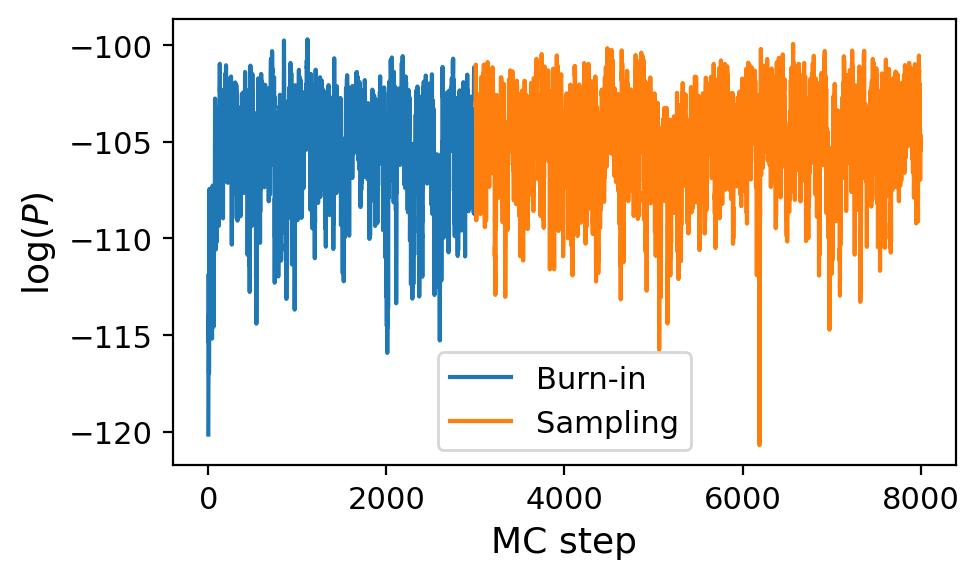

In [1564]:
plot_stat(burnin_stats_edges, sampling_stats_edges, stat_name='log_P', stat_label=r'$\log(P)$',
         path='../Figures/case_study_small_edges_log_P_vs_MC_step.png')

In [1565]:
# Take 1 every 10 samples, to reduce the correlation
edge_samples_nocorr = dict()
for e in edge_samples:
    edge_samples_nocorr[e] = np.array(edge_samples[e])[::10]

In [1583]:
# Now we can estimate the mean and std for each edge
edge_stats = dict()
for e in edge_samples_nocorr:
    samples_e = edge_samples_nocorr[e]
    mean_e = round(np.mean(samples_e), 2)
    std_e = round(np.std(samples_e), 1)
    edge_stats[e] = str(mean_e) #+ '\n±' + str(std_e)

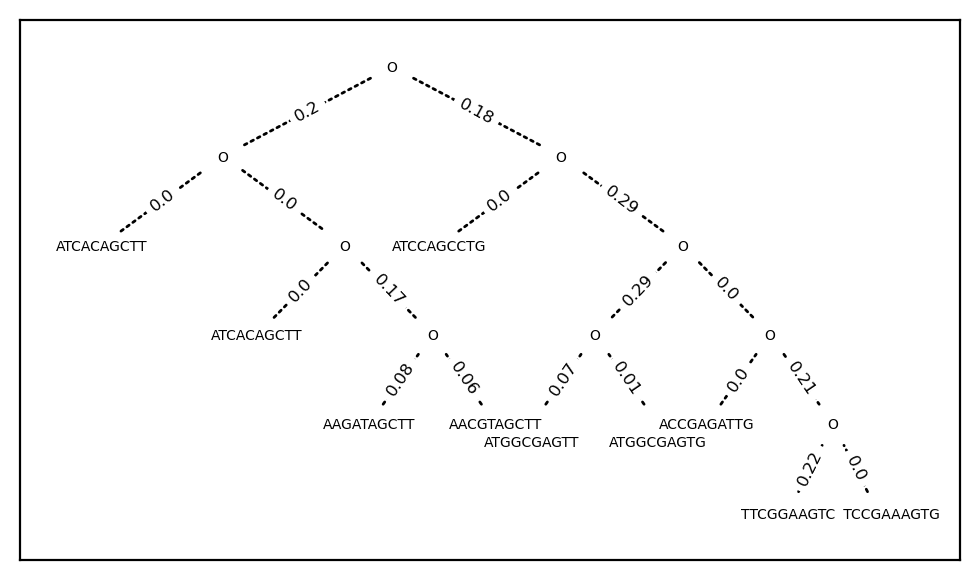

In [1584]:
# Finally, we can plot the MAP with the Bayesian estimated edge lengths
comp_labels = build_comp_labels(MAP_G, leaf_labels_inf)
comp_labels[6] = '      ' + comp_labels[6]
comp_labels[10] = '\n\n' + comp_labels[10]
comp_labels[14] = '\n\n' + comp_labels[14]

visualize_phylogenetic_tree_Bayes(
    MAP_G, comp_labels, edge_stats, node_size=0, dy=2,
    dx_decay=0.72, edge_font_size=6, node_font_size=5, 
    path='../Figures/case_study_small_MAP_Bayes_edges_tree_n_10_m_10.png')